In [1]:
!pip install -qq textstat lexicalrichness

In [2]:
import os
import re

from datasets import load_from_disk
from lexicalrichness import LexicalRichness
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns
import textstat

In [3]:
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'Helvetica, sans-serif'
plt.rcParams['font.size'] = 6.5
plt.rcParams['lines.linewidth'] = .5
plt.rcParams['axes.linewidth'] = .5
plt.rcParams['grid.linewidth'] = .25


def plot_length_dist(df, col, title, xrange, savefig=None, **hist_args):
    df = df.sort_values(by='model')
    bins = np.linspace(*xrange, 40)
    models = [m for m in df['model'].unique() if m != 'human']
    n_cols = 4
    n_rows = np.ceil(len(models) / n_cols).astype(int)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6.3, min(9.5, n_rows + .5)), sharex=True, sharey=True)
    axes = axes.flatten() if type(axes) == np.ndarray else [axes]

    for i, m in enumerate(models):
        ax = axes[i]
        df_filtered = df.query('model in ["human", @m]').sort_values(by='model', key=lambda c: c.str.strip() != 'human')
        sns.histplot(ax=ax, data=df_filtered, x=col, hue='model', bins=bins, kde=True, stat='percent', **hist_args)
        ax.set_xlabel(None)
        ax.set_xlim(xrange[0] - 1, xrange[1] + 1)
        ax.yaxis.set_major_formatter(mticker.PercentFormatter(symbol='\u2009%'))
        ax.set_ylabel(None)
        ax.set_ylim((0, 17))
        means = df_filtered[['model', col]].groupby('model').mean()

        df_h = df_filtered.query('model == "human"')[col]
        df_m = df_filtered.query('model == @m')[col]
        t = ttest_ind(df_h, df_m)
        pvalue = f'{max(.001, t.pvalue):,.3f}'.strip('0')
        tvalue = f'{t.statistic:,.1f}'.strip('0')
        dof = f'{len(df_filtered) - 2:,}'
        cohens_d = f'{t.statistic * np.sqrt((len(df_h) + len(df_m)) / (len(df_h) * len(df_m))):,.2f}'.strip('0')
        decimals = 1 if means[col].mean() < 100 else 0
        ax.text(.025, .95, m, weight='bold', ha='left', va='top', transform=ax.transAxes)
        ax.text(.025, .826, f'$\\mu_h$ = {means.loc['human'].values[0]:,.{decimals}f}, $\\mu_m$ = {means.loc[m].values[0]:,.{decimals}f},\n'
                            f't({dof}) = {tvalue}, $p$ {"=" if t.pvalue >= .001 else "<"} {pvalue}, $d$ = {cohens_d}',
            ha='left', va='top', transform=ax.transAxes, fontsize=plt.rcParams['font.size'] - 1)
        ax.get_legend().set_visible(False)

    fig.suptitle(title, fontsize=plt.rcParams['font.size'], fontweight='bold', ha='left', x=.1)
    fig.supylabel('Percent of Data', fontsize=plt.rcParams['font.size'], fontweight='bold')
    fig.legend(['Machine', 'Human'], bbox_to_anchor=(.999, 1.), loc='upper right', ncol=2, frameon=False)

    plt.tight_layout(pad=0.8)
    plt.subplots_adjust(wspace=.025, hspace=.05)    # Need to layout twice to fix right margin issues
    plt.tight_layout(pad=0.8)
    plt.subplots_adjust(wspace=.025, hspace=.05)

    if savefig:
        os.makedirs(os.path.dirname(savefig), exist_ok=True)
        fig.savefig(savefig)
    plt.show()

In [4]:
_ws_re = re.compile(r'\s+')

def mean_word_len(text):
    return np.mean([len(c) for c in _ws_re.split(text.strip())])

def mtld(text):
    try:
        return LexicalRichness(text).mtld()
    except ZeroDivisionError:
        return 0.

def load_data(dataset, split='train'):
    return (load_from_disk(dataset)[split]
            .map(lambda x: {
                'len': len(x['text']),
                'word_len': mean_word_len(x['text']),
                'ease': textstat.flesch_reading_ease(x['text']),
                'mtld': mtld(x['text'])
            }, num_proc=len(os.sched_getaffinity(0)) - 1)
            .to_pandas())

def create_plots(df, title_prefix, file_prefix):
    plot_length_dist(df, 'len', f'{title_prefix}: Text Length (Characters)', xrange=(0, 7900), savefig=f'../data/figures/{file_prefix}-text-length.pdf')
    plot_length_dist(df, 'word_len', f'{title_prefix}: Mean Word Length (Characters)', xrange=(3.5, 7), savefig=f'../data/figures/{file_prefix}-word-length.pdf')
    plot_length_dist(df, 'ease', f'{title_prefix}: Flesch Reading Ease', xrange=(0, 110), savefig=f'../data/figures/{file_prefix}-reading-ease.pdf')
    plot_length_dist(df, 'mtld', f'{title_prefix}: MTLD', xrange=(0, 250), savefig=f'../data/figures/{file_prefix}-mtld.pdf')

In [5]:
df_pan = load_data('../data/datasets/pan24-converted').query('not model.str.contains("contrastive")')

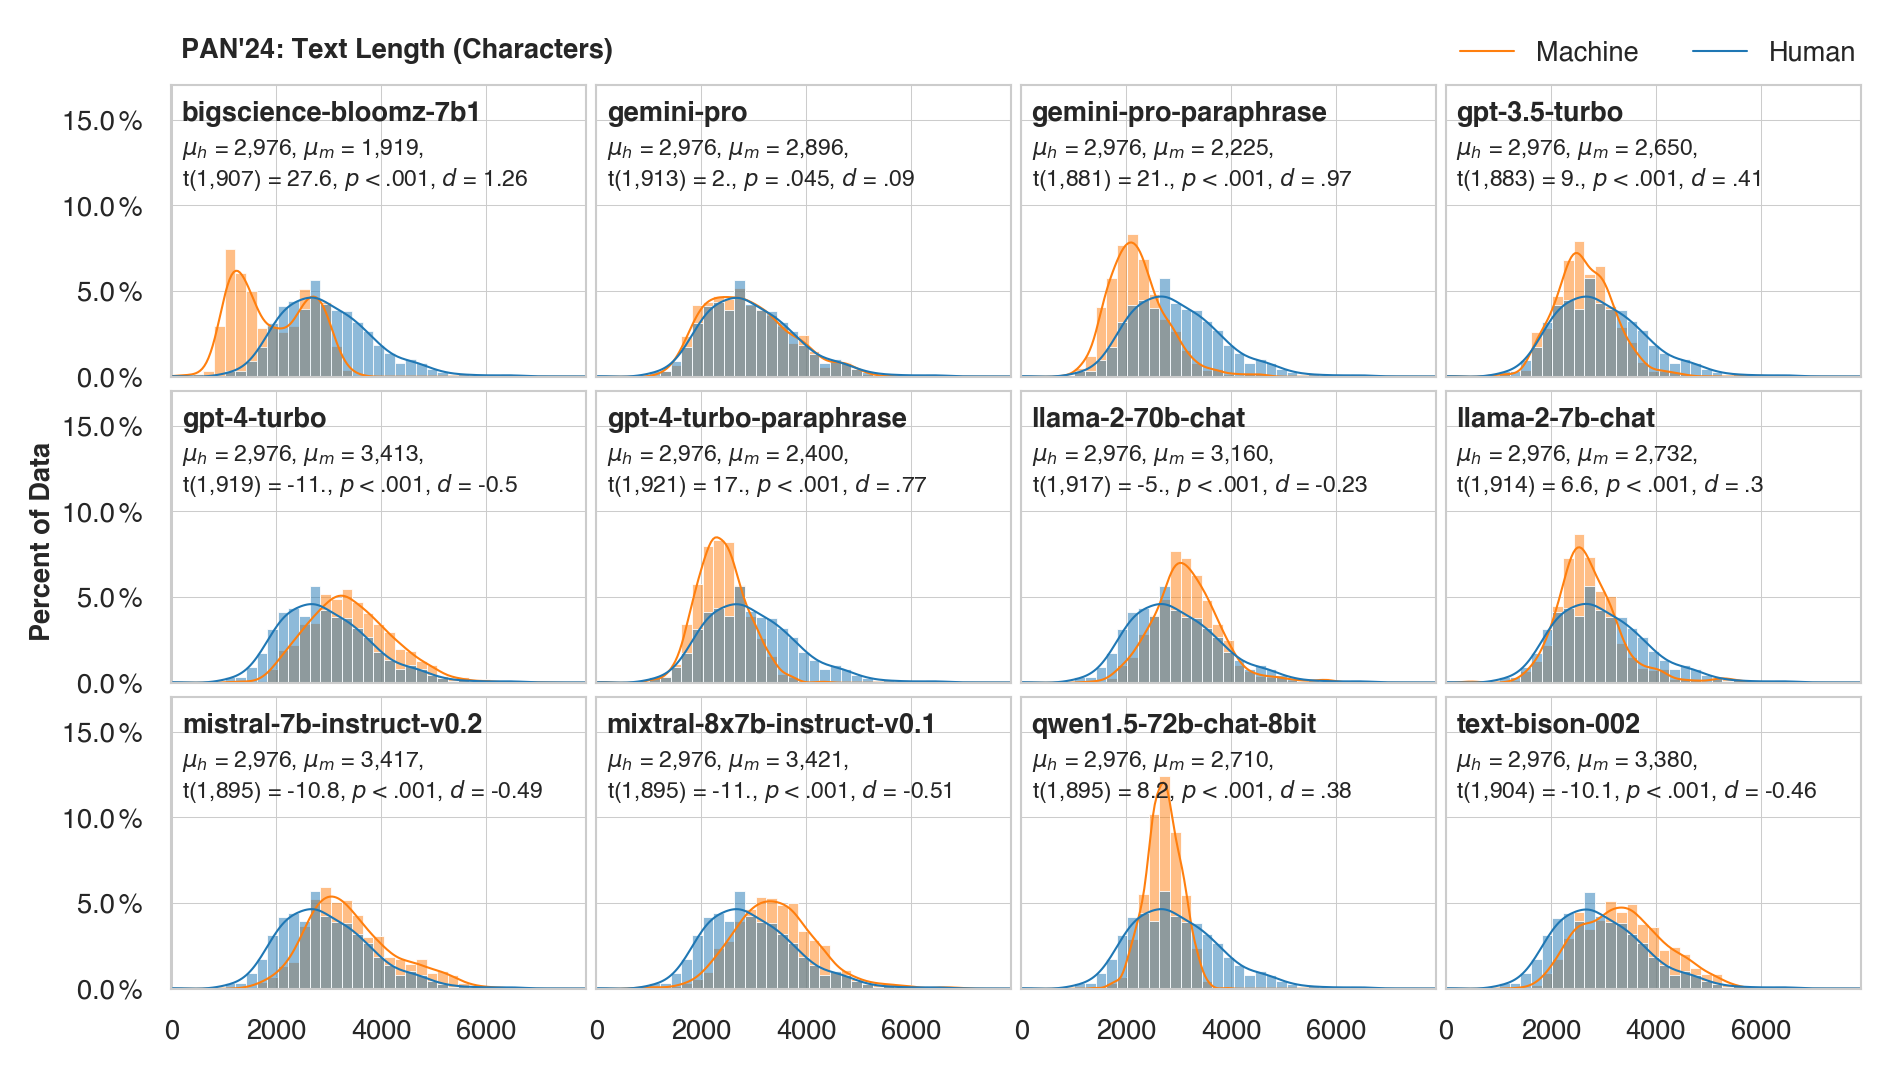

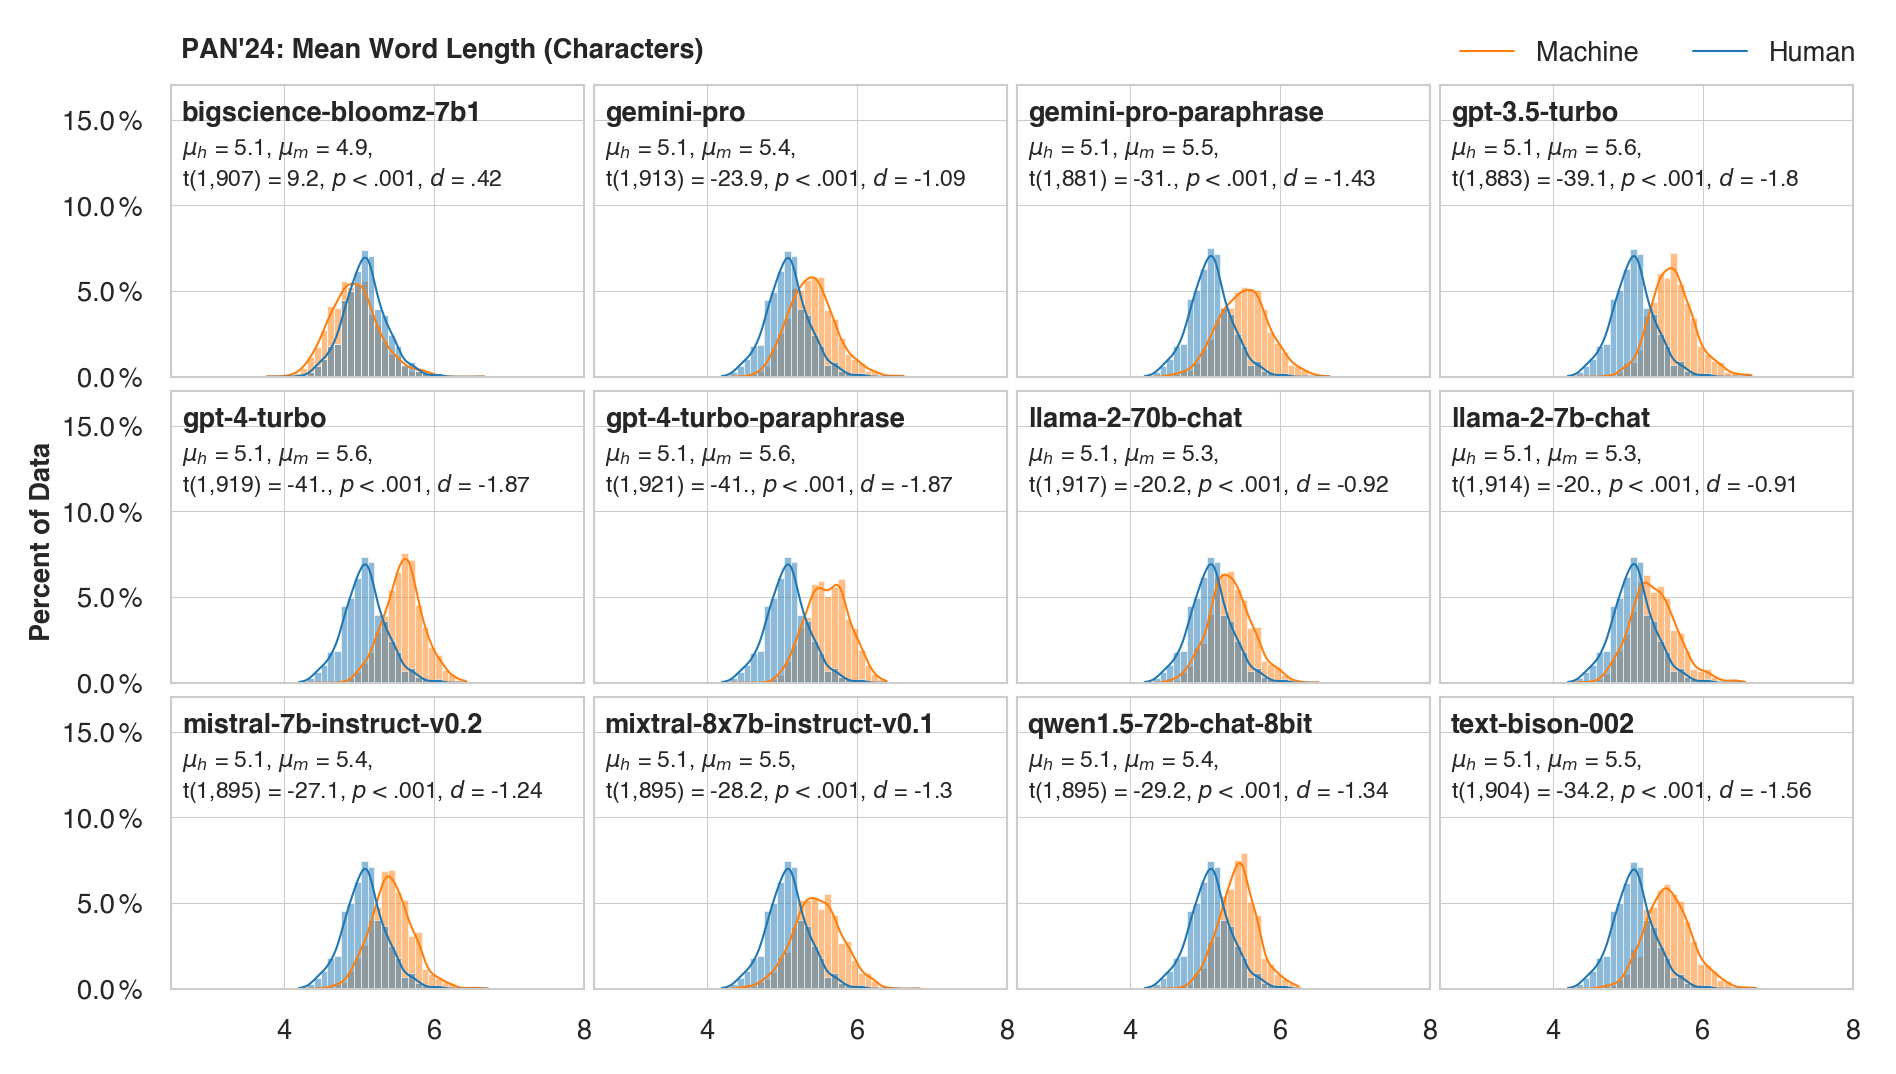

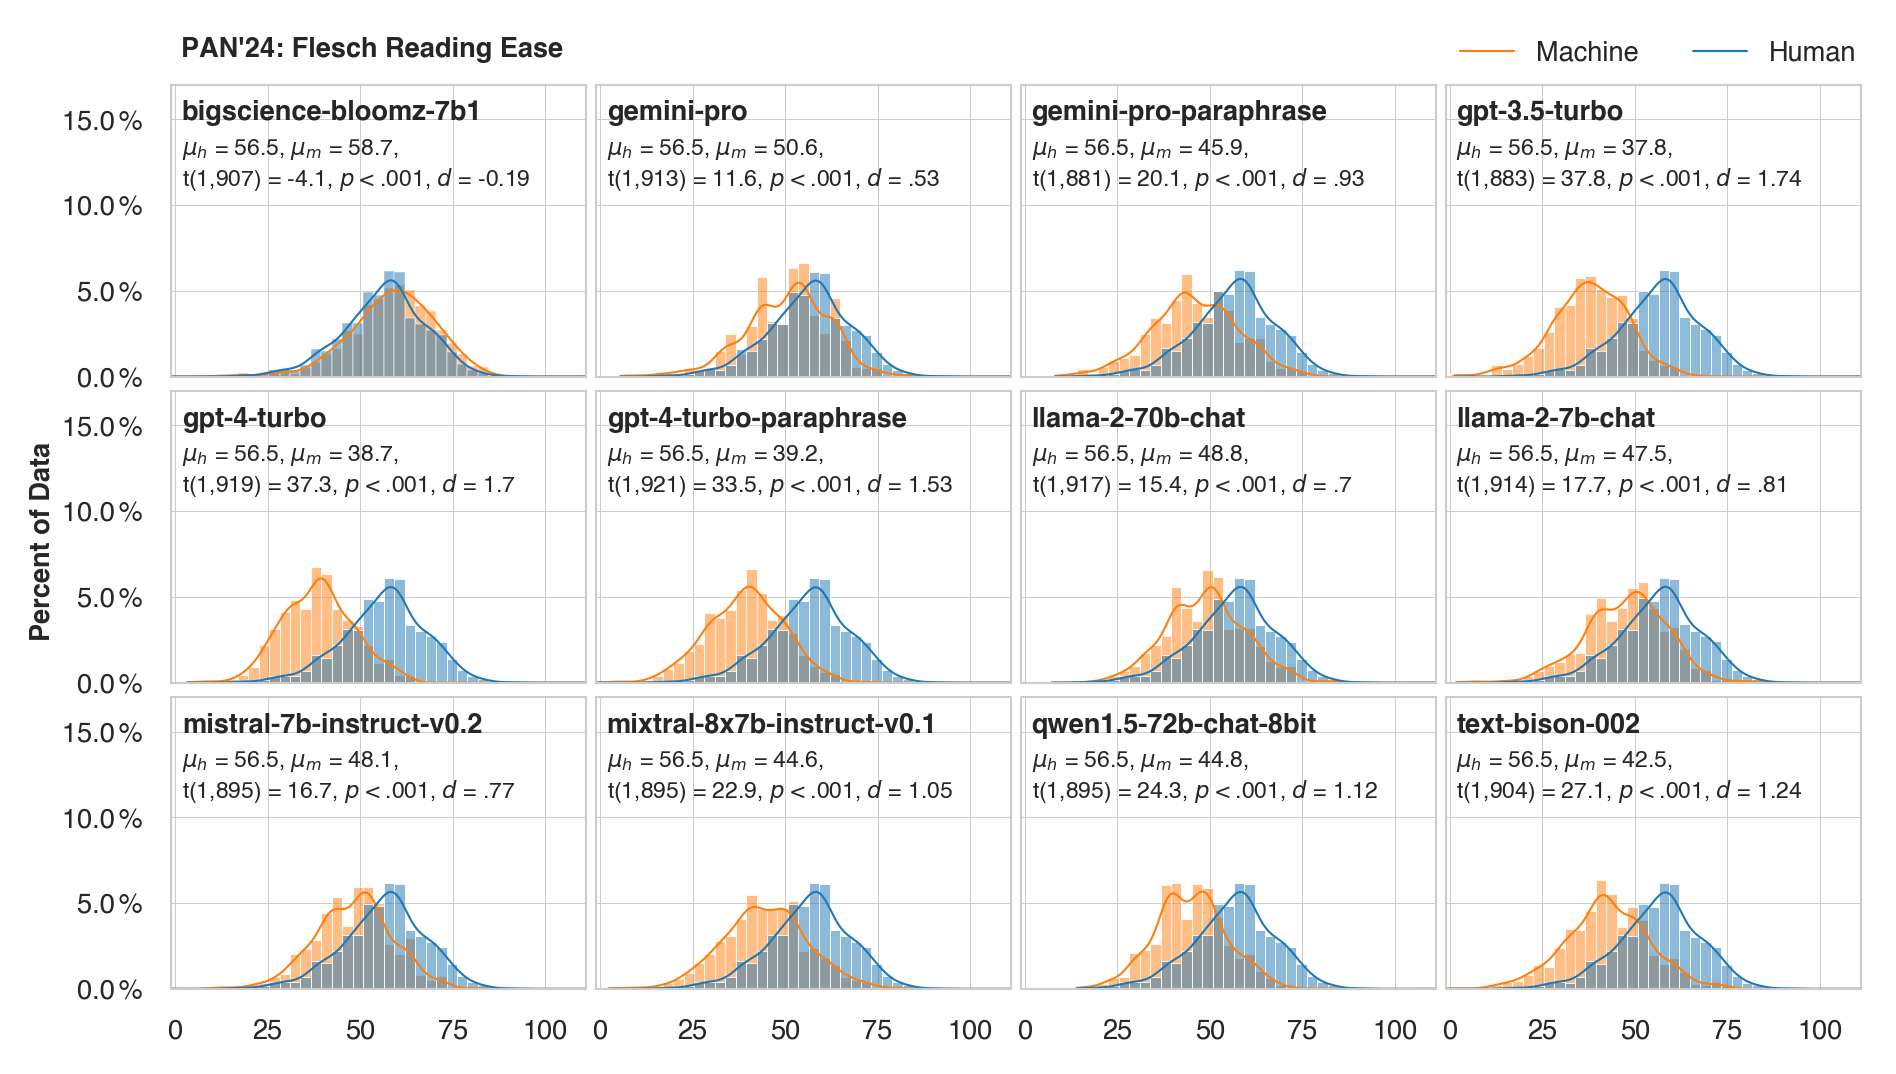

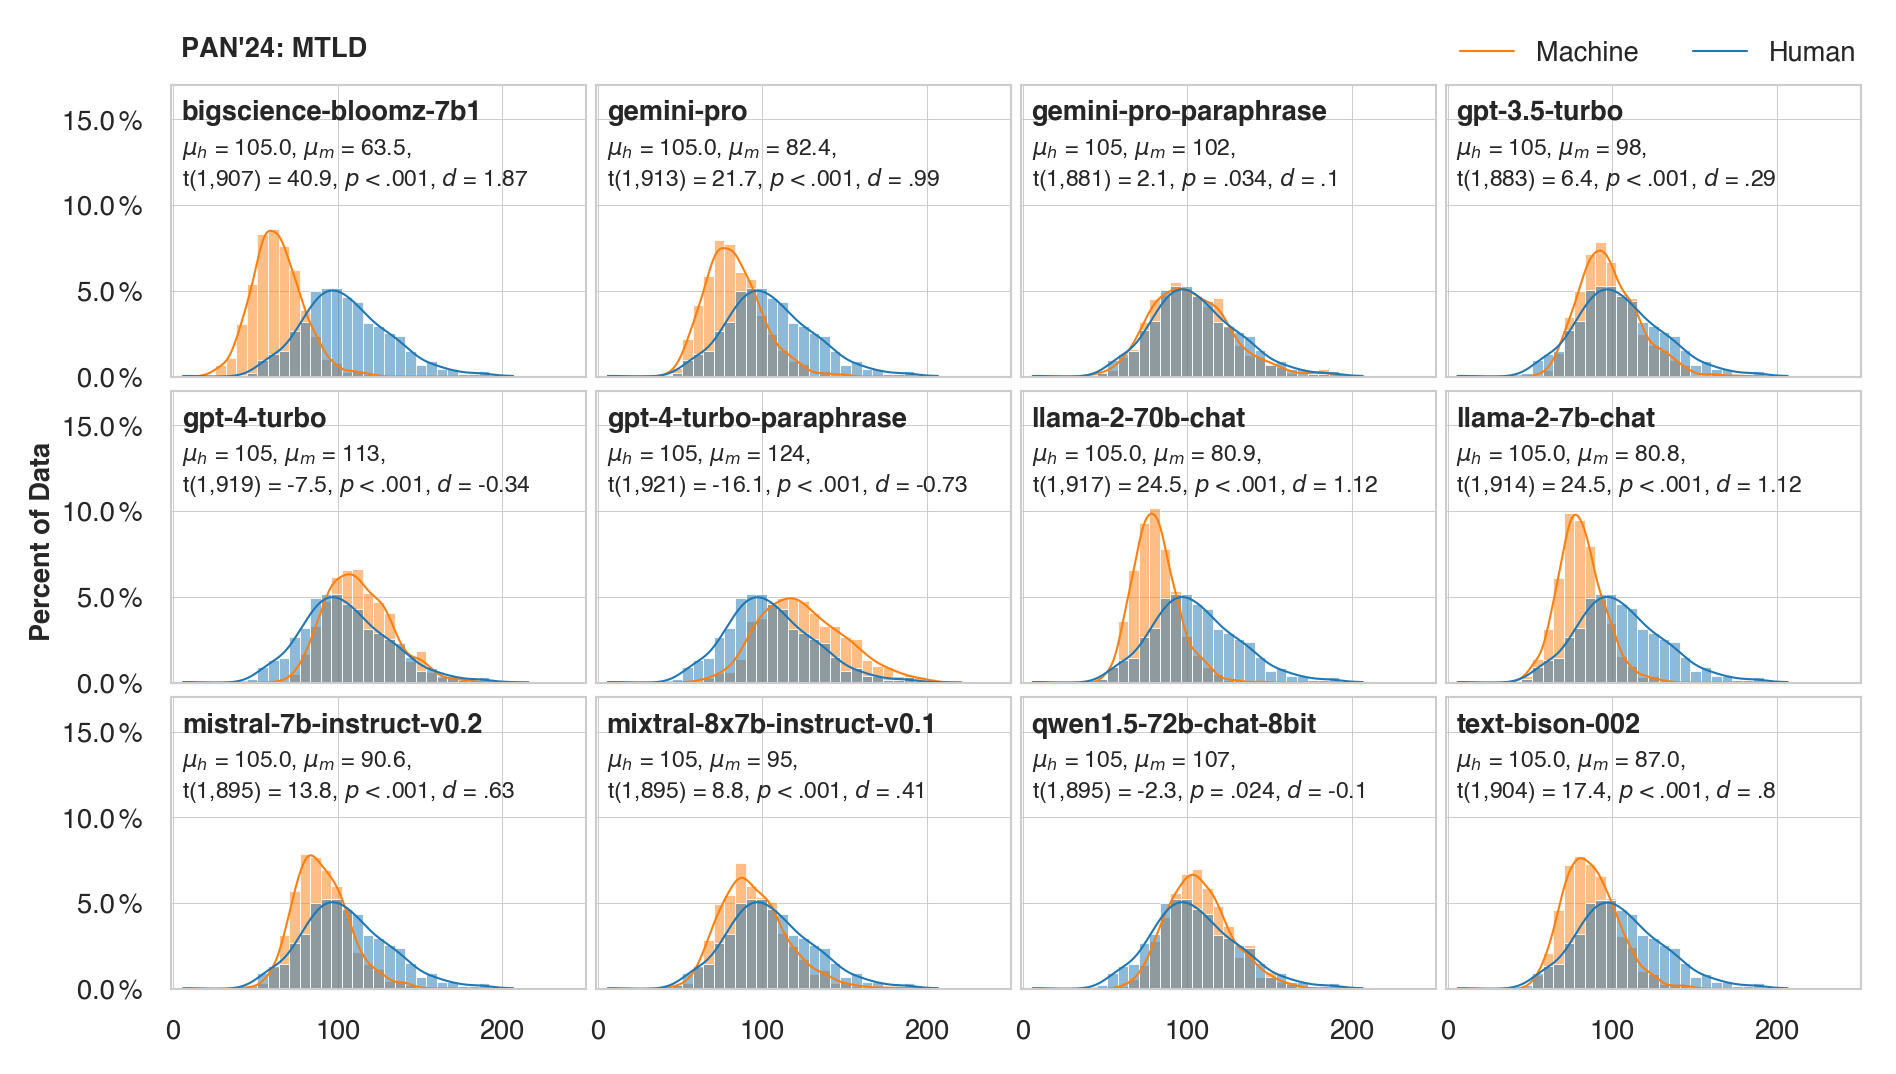

In [6]:
create_plots(df_pan, 'PAN\'24', 'pan24')

In [7]:
df_pan_extended = load_data('../data/datasets/pan24-extended-converted').query('not model.str.contains("contrastive")')

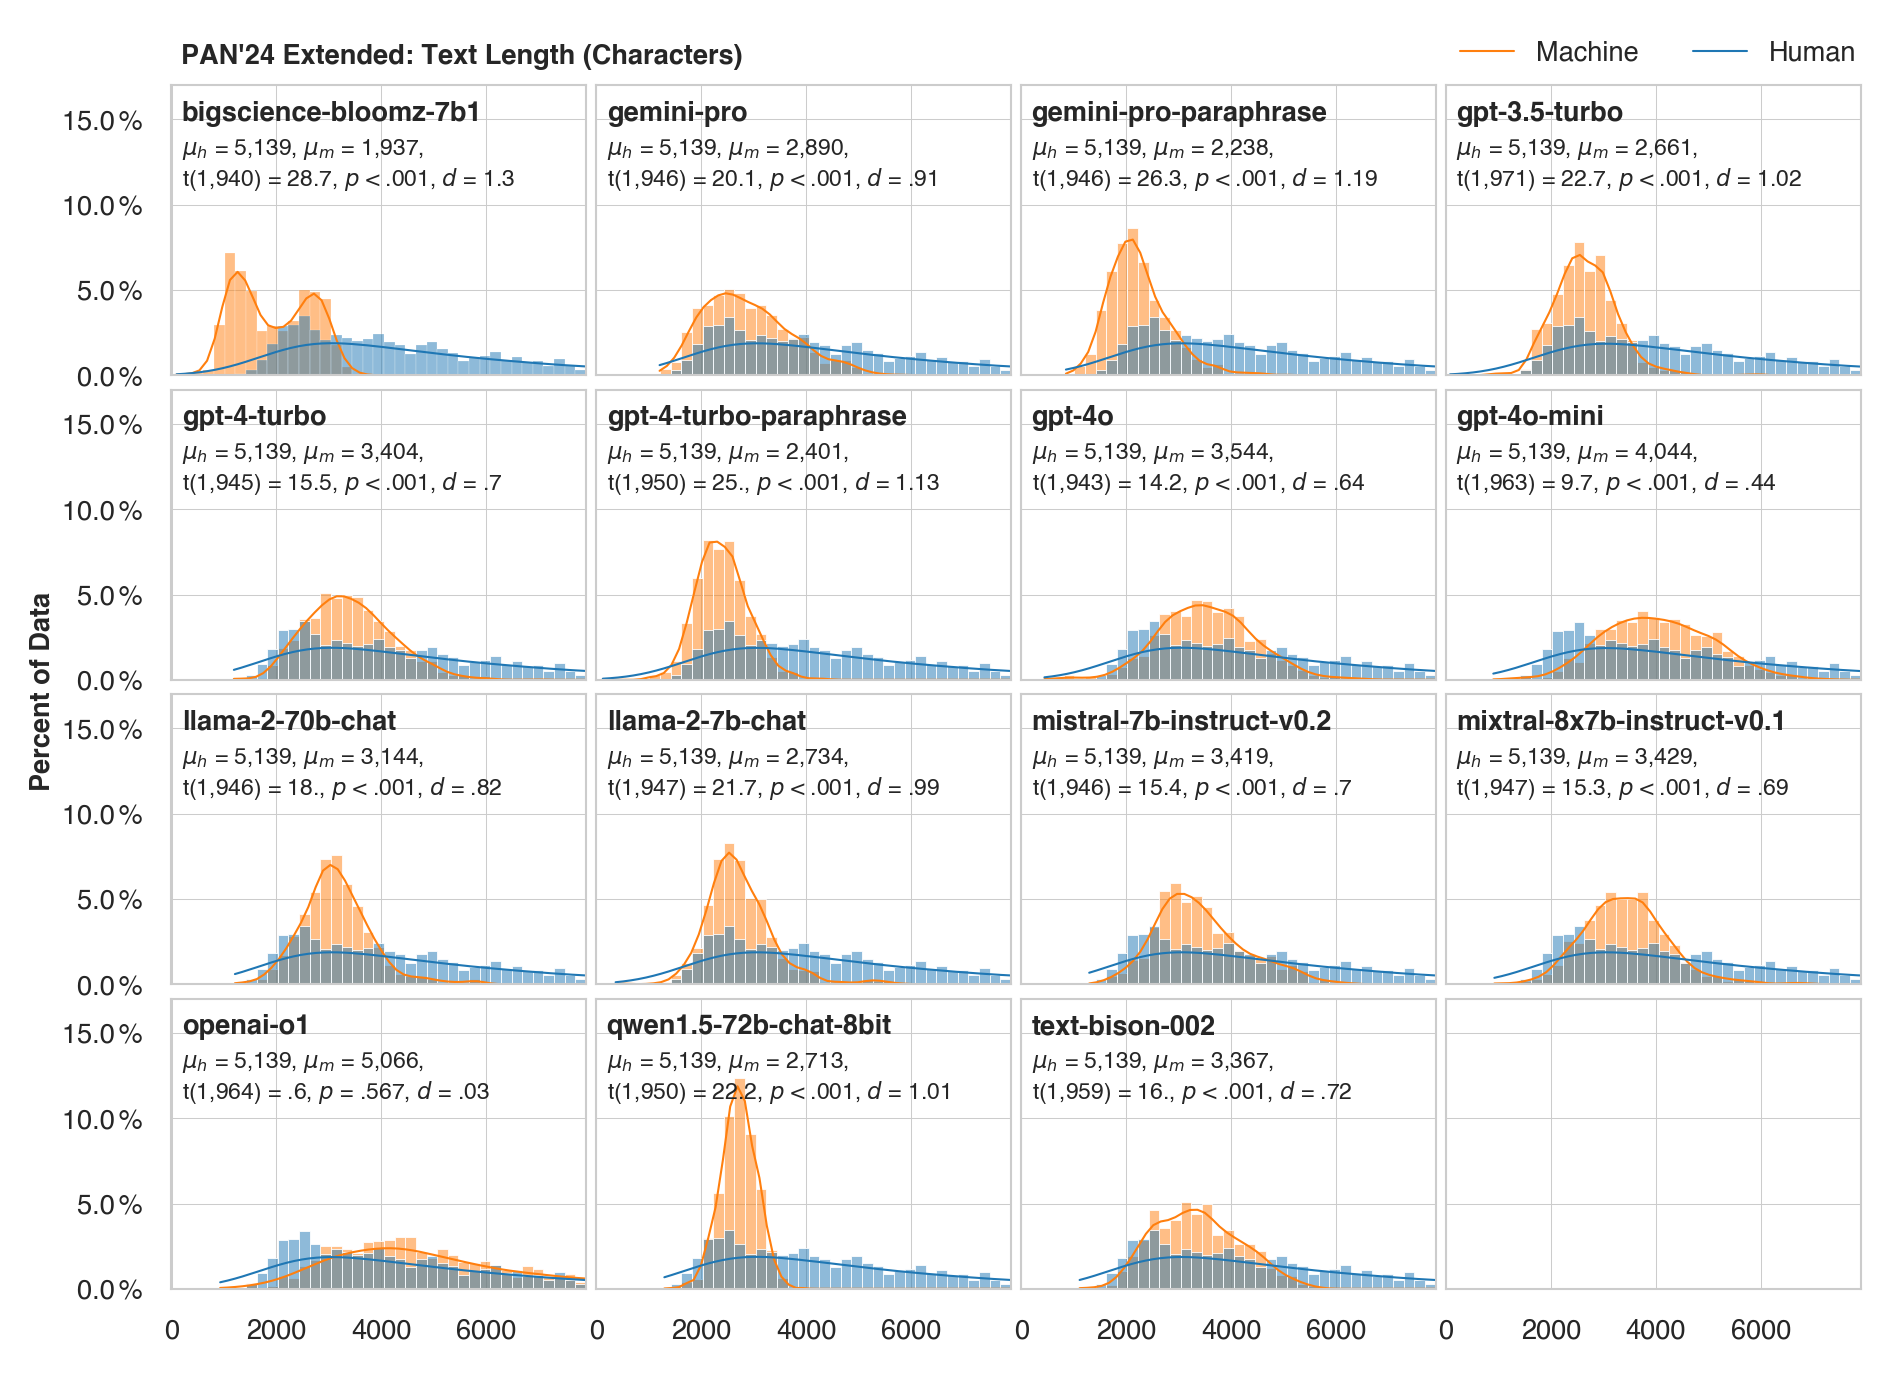

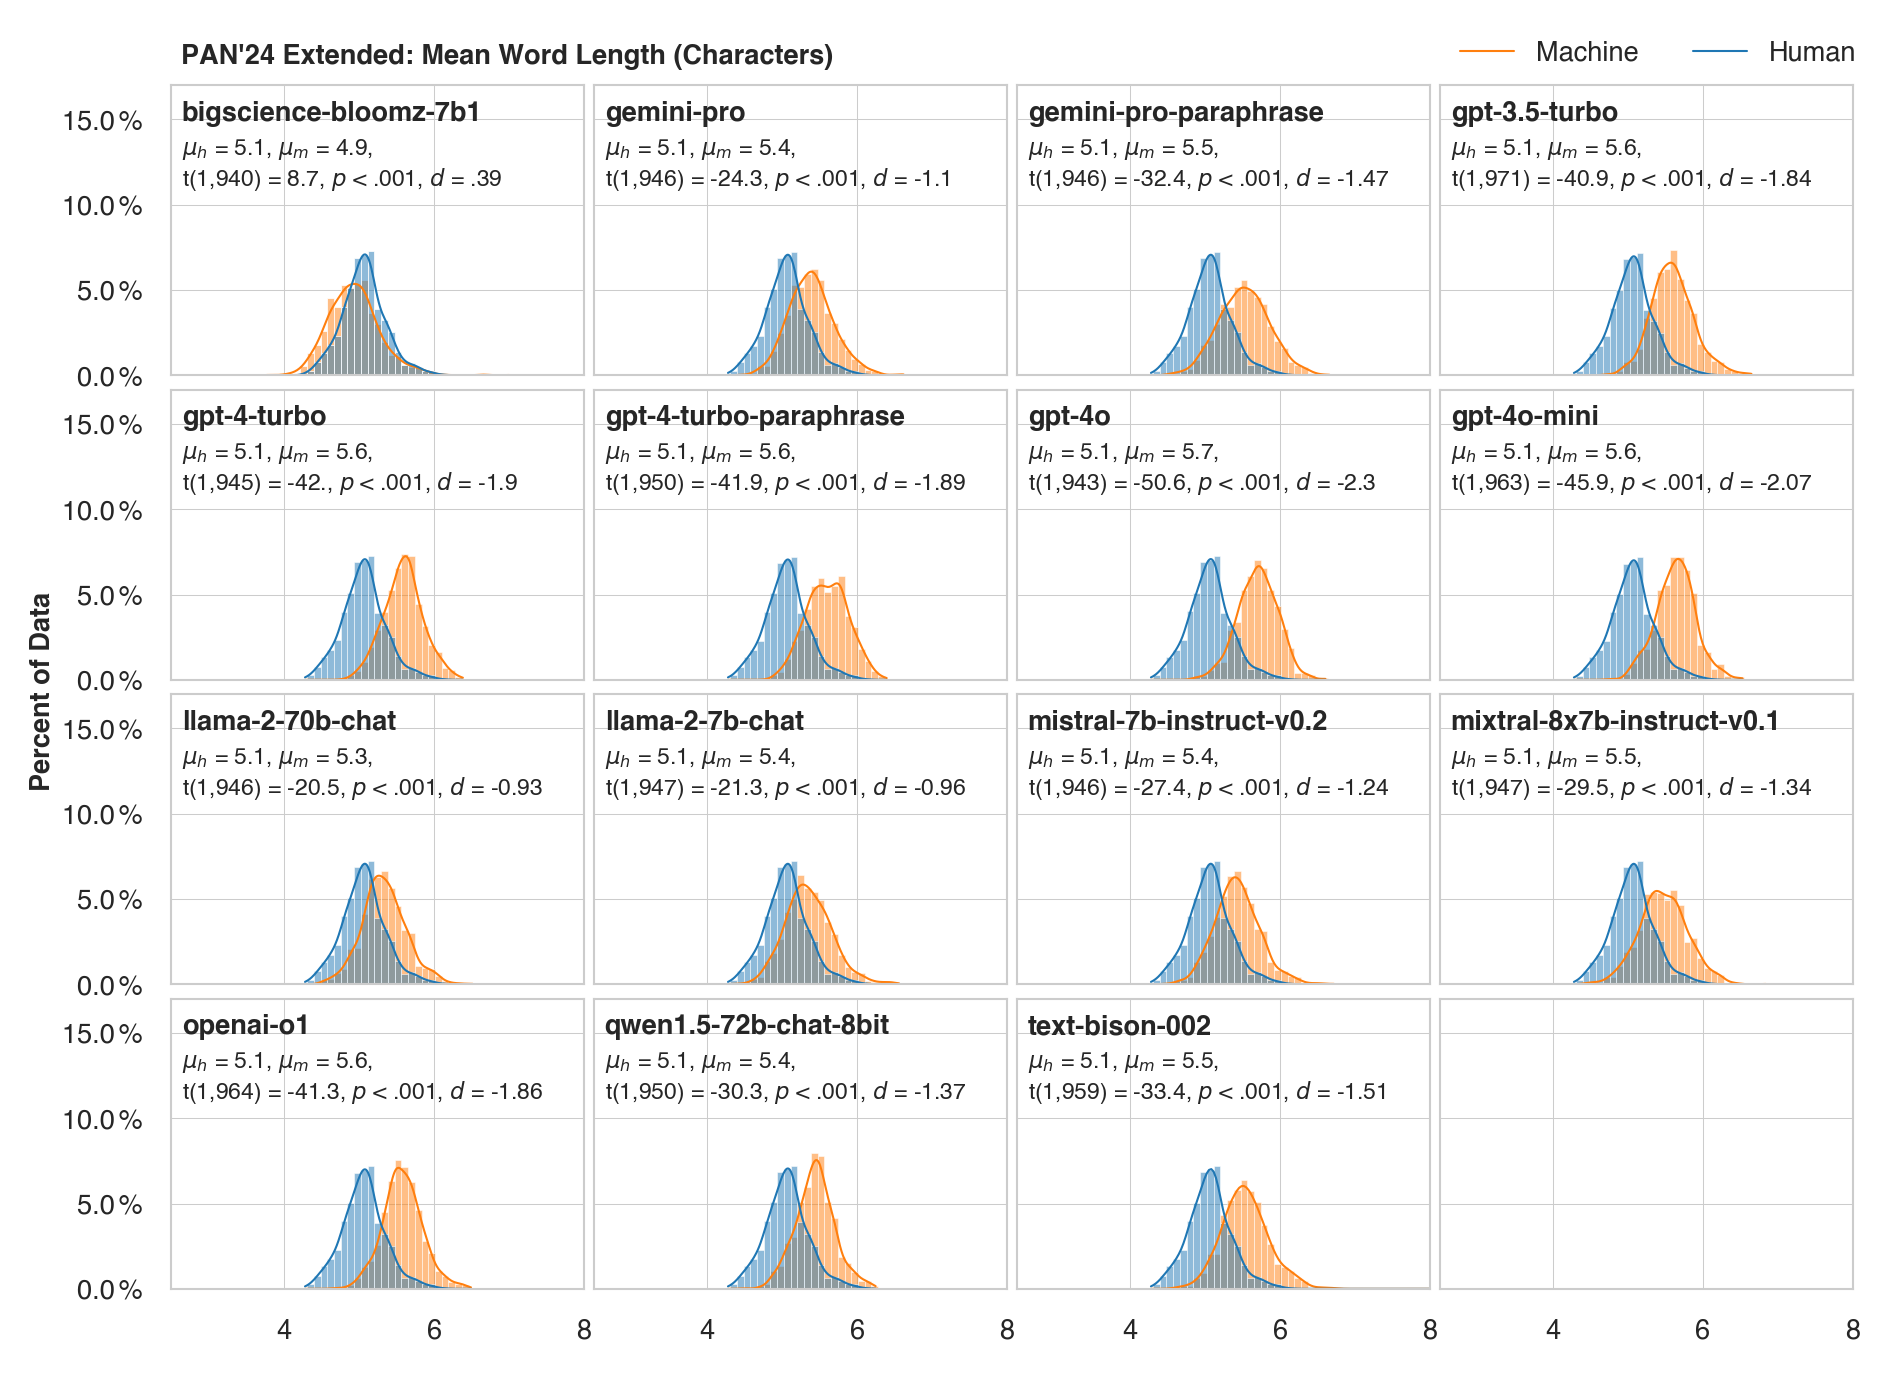

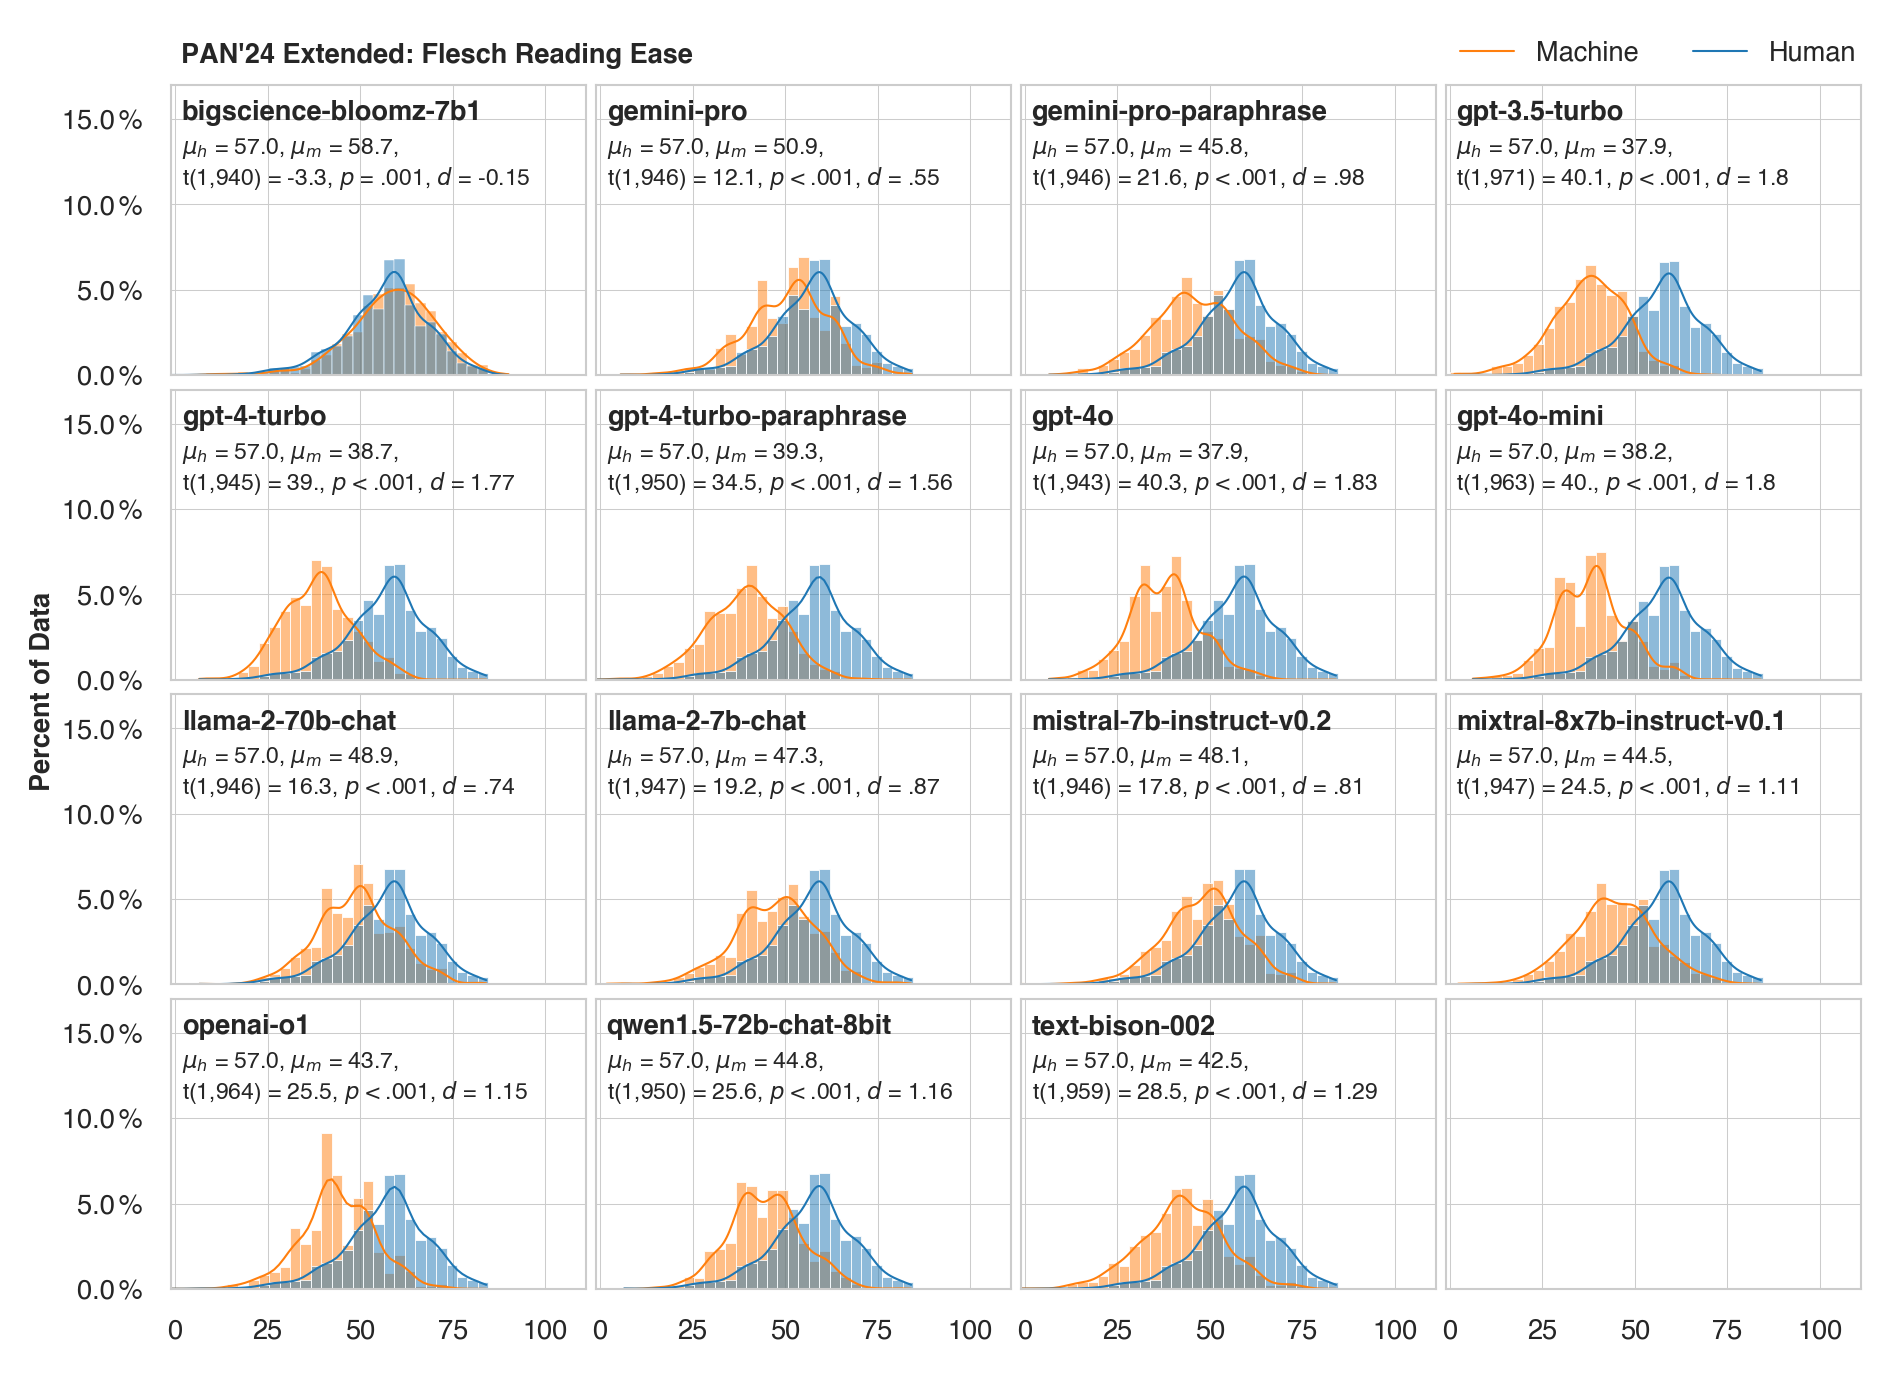

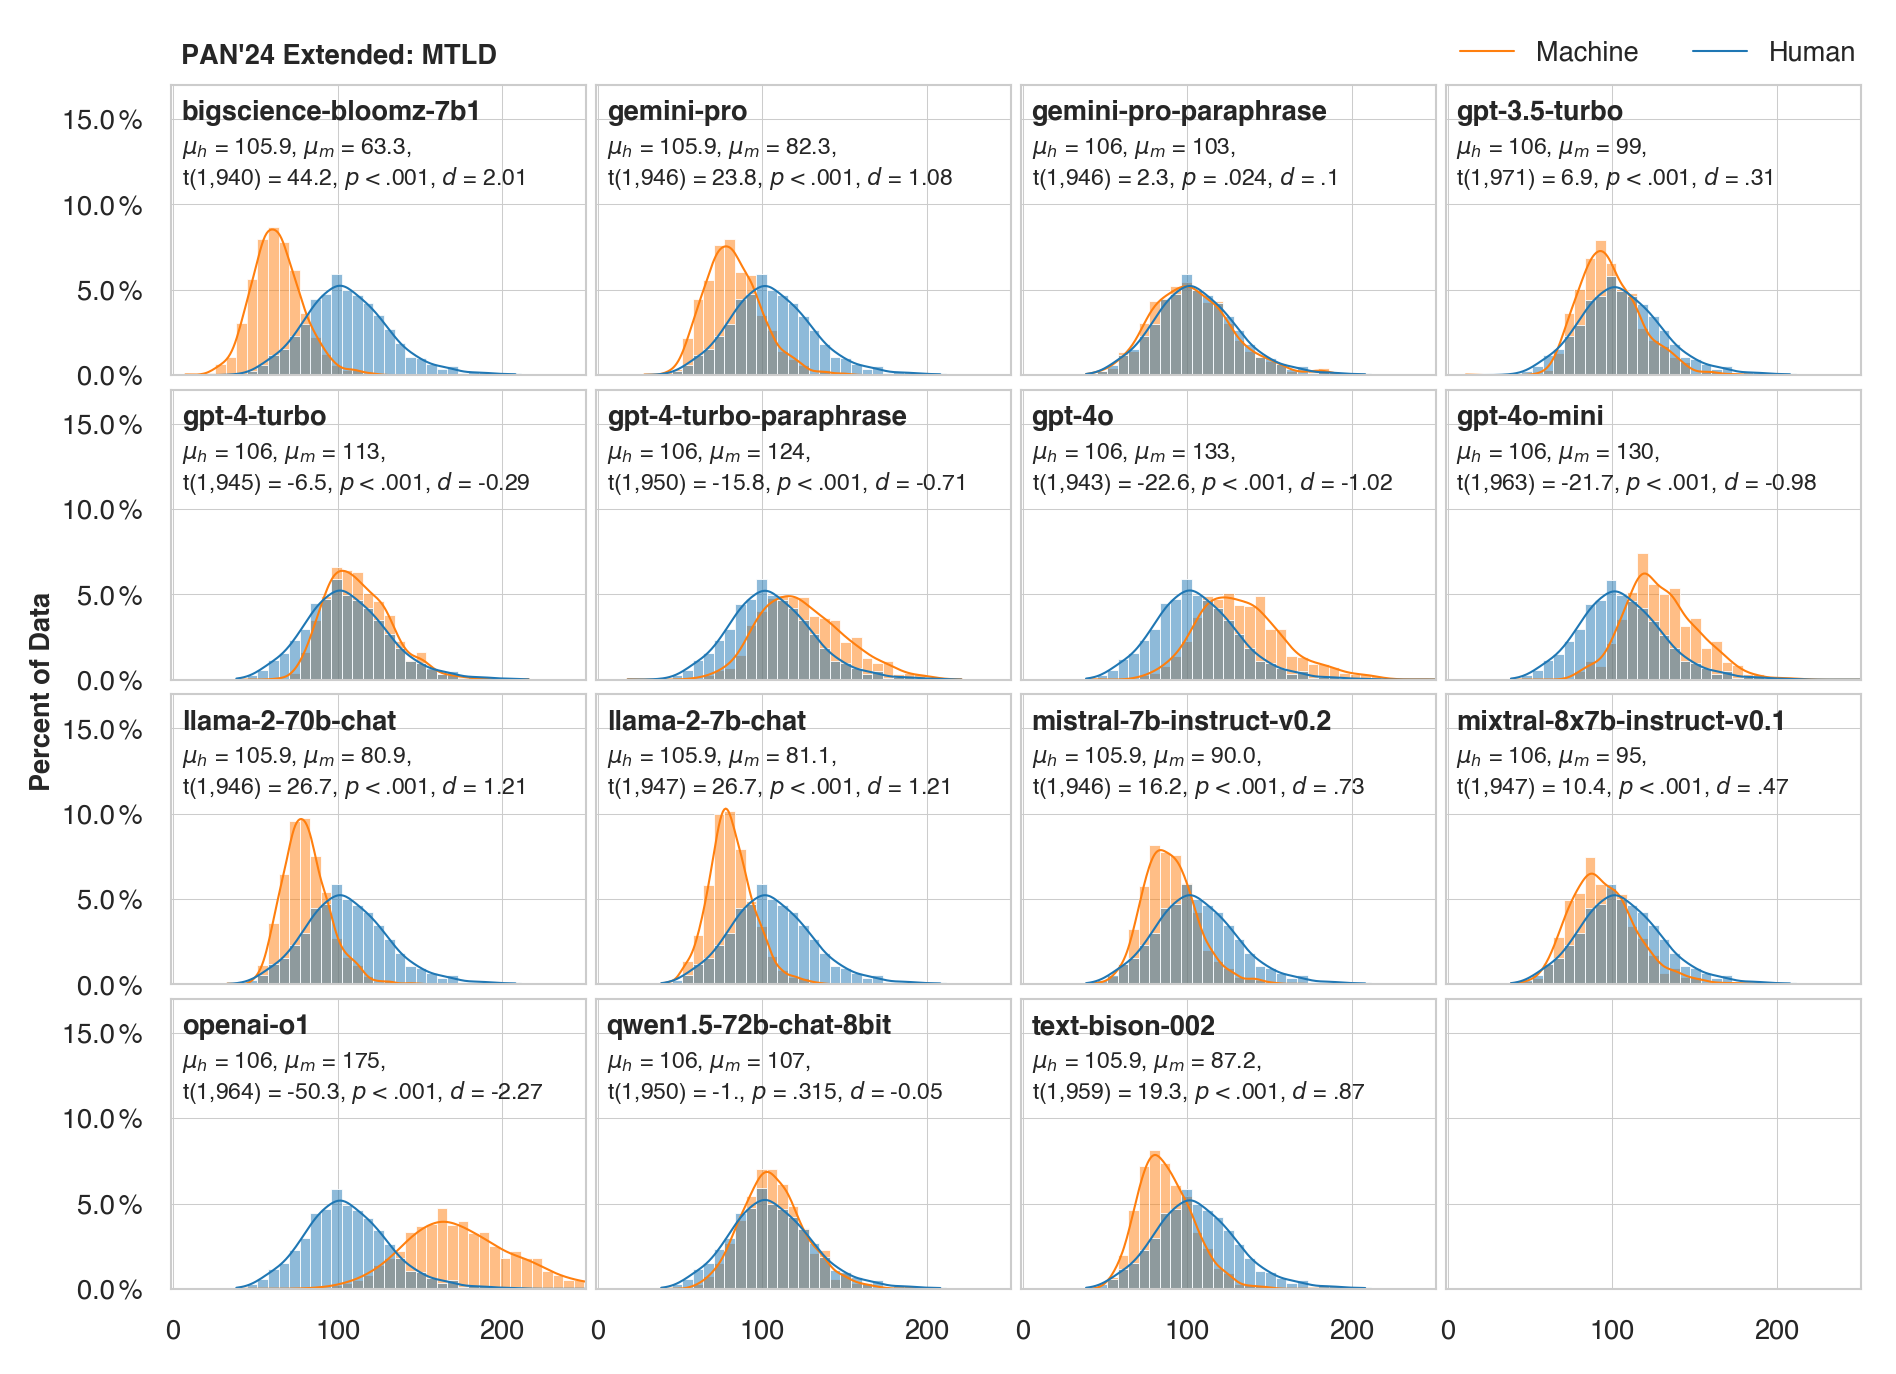

In [8]:
create_plots(df_pan_extended, 'PAN\'24 Extended', 'pan24-extended')

In [9]:
df_raid = load_data('../data/datasets/raid-good-models-no-attack-converted').query('word_len < 50') # Filter outliers such as AAAAAAAAAAAAAAAAAA...

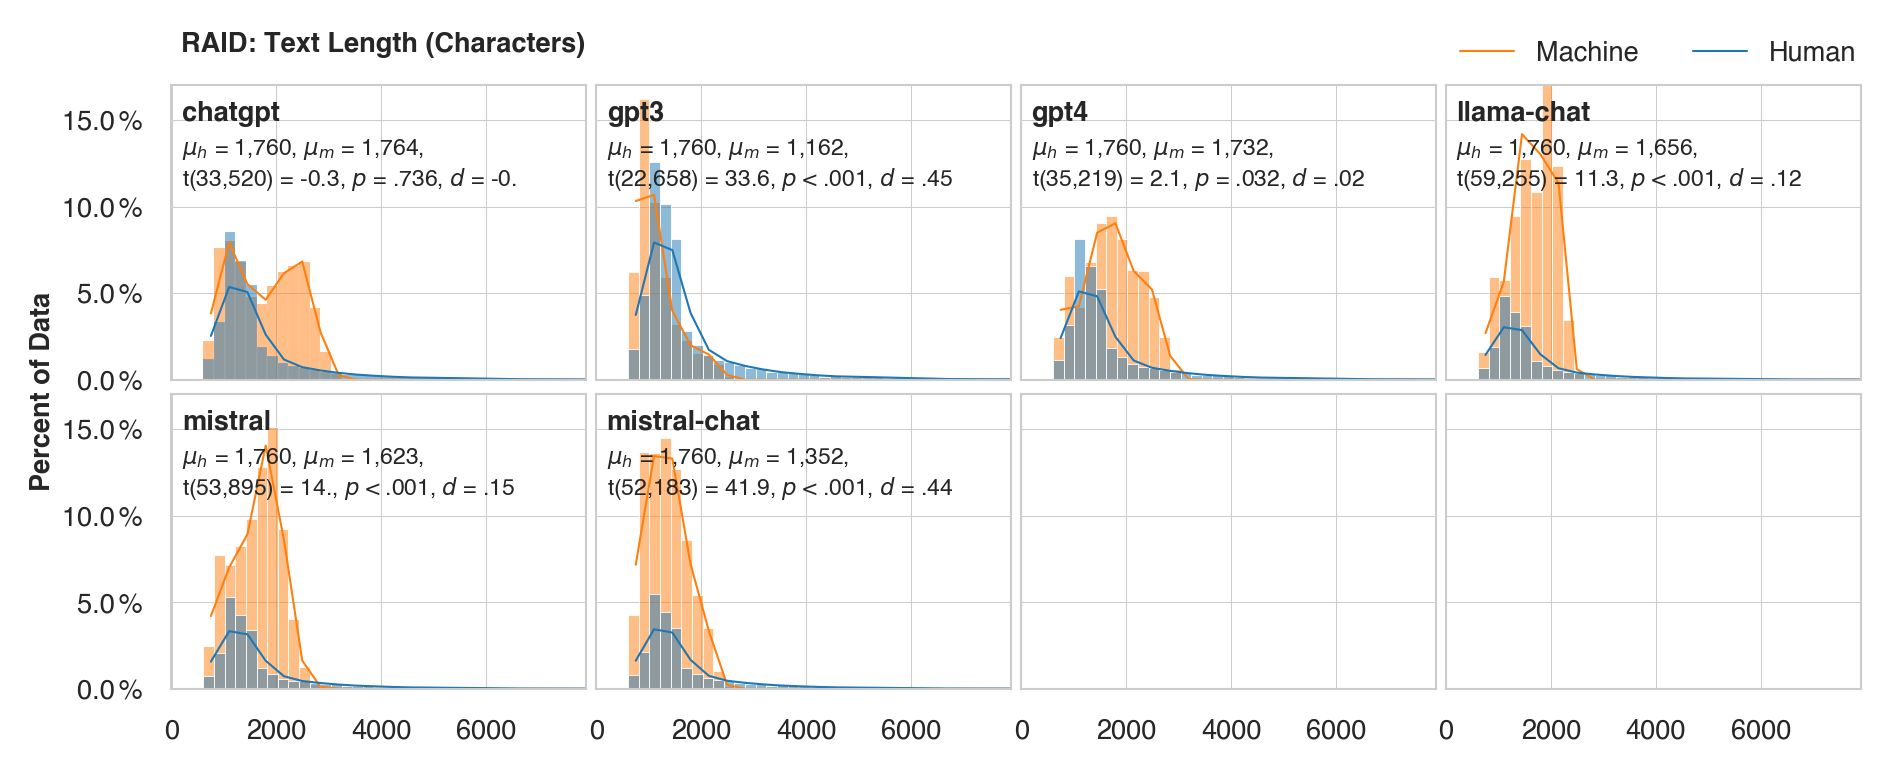

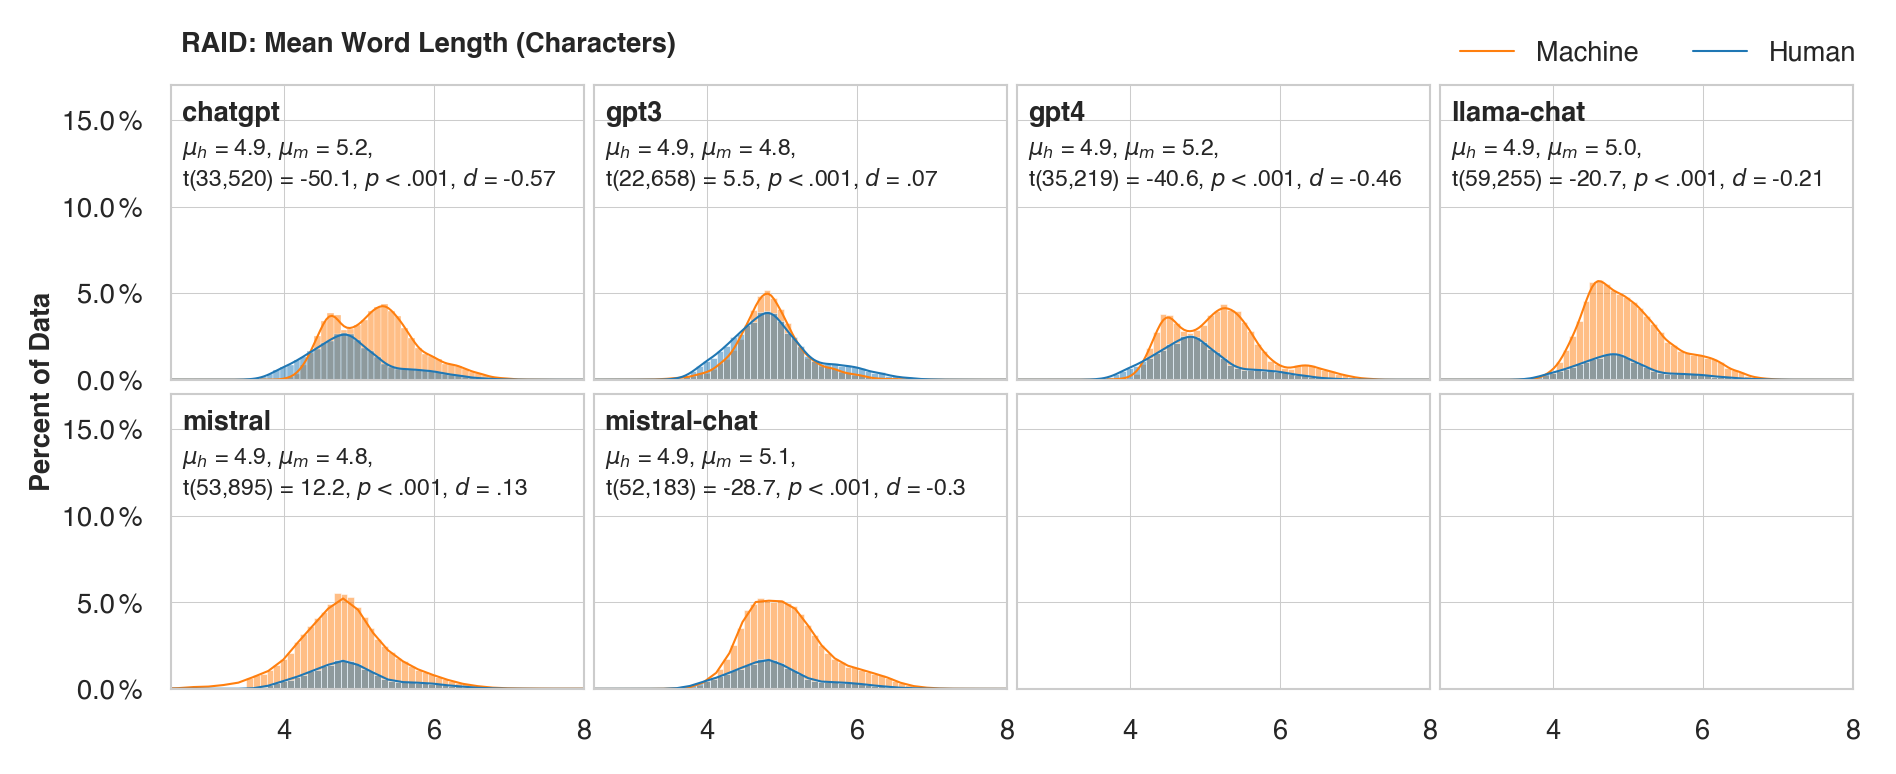

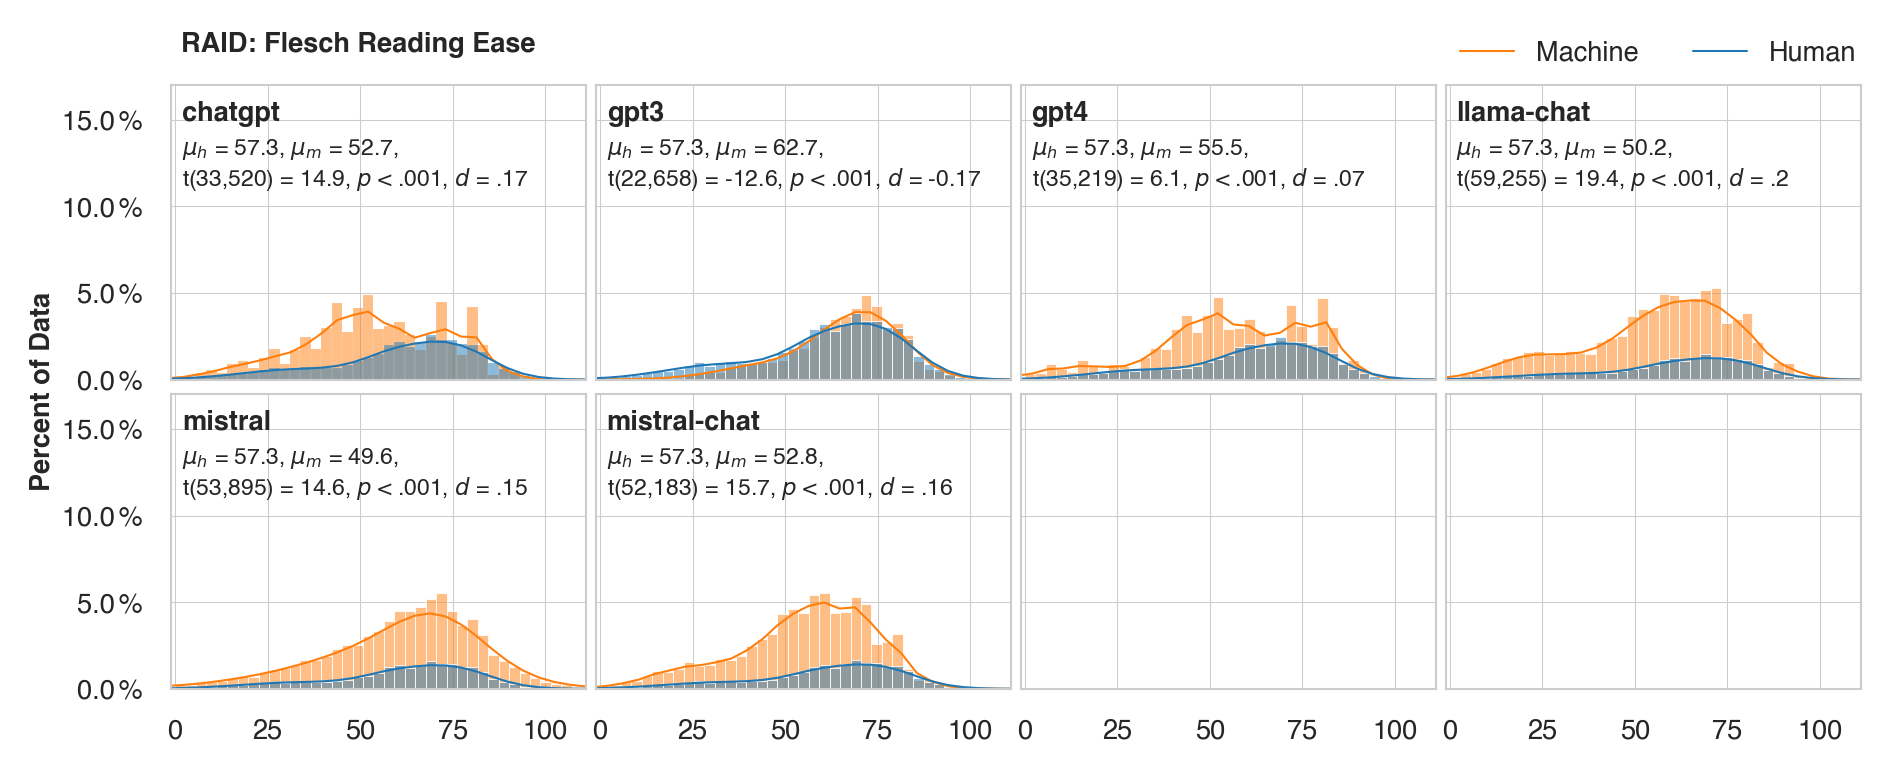

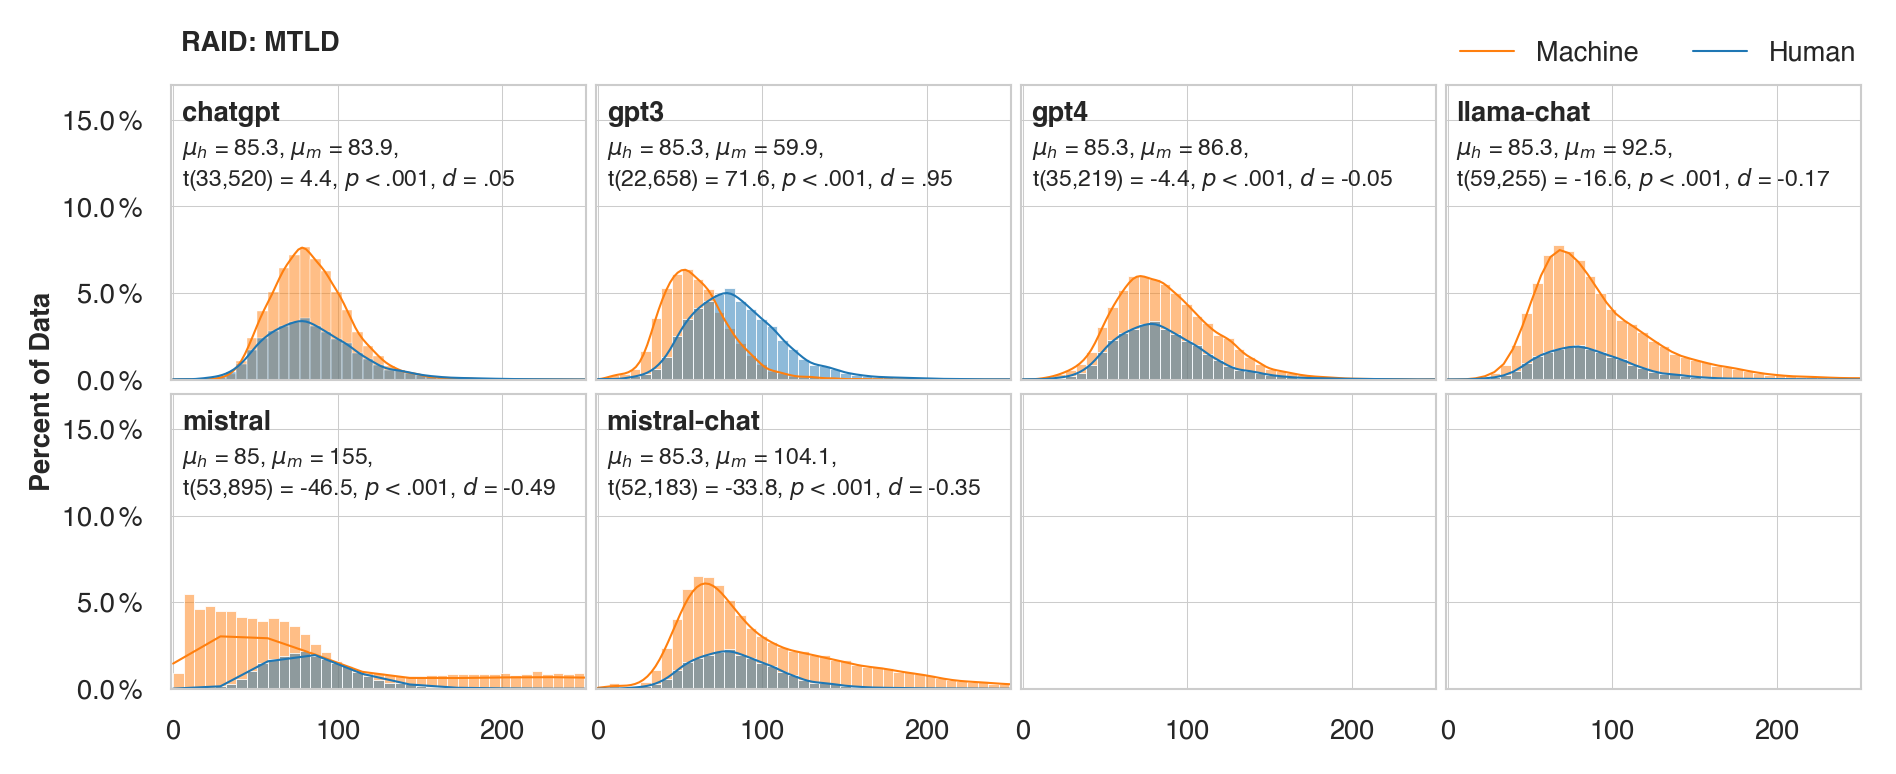

In [10]:
create_plots(df_raid, 'RAID', 'raid')

In [11]:
# Very high word_len variance due to extreme outliers (need to be filtered above)
df_raid[['model', 'word_len']].groupby('model').var()

word_len
model                 
chatgpt       0.311304
gpt3          0.203020
gpt4          0.382960
human         0.349708
llama-chat    0.329328
mistral       0.535009
mistral-chat  0.360113

In [12]:
load_data('../data/datasets/raid-good-models-no-attack-converted').query('word_len > 100')[['model', 'word_len', 'text']]  # Longest words unfiltered

model  word_len  \
31880          human     955.0   
60412           gpt3    4080.0   
63096   mistral-chat    3577.0   
90078        mistral    1809.0   
114161       mistral    1809.0   
181876  mistral-chat    3577.0   
184981         human    1517.0   

                                                     text  
31880   pleeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee...  
60412   \n\nAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...  
63096   AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...  
90078   > AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...  
114161  > AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...  
181876  AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...  
184981  AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...

In [13]:
df_raid[['model', 'word_len', 'text']].sort_values(ascending=False, by='word_len')

model   word_len  \
97749        mistral  40.666667   
172462  mistral-chat  36.238095   
197085       mistral  33.434783   
53824        mistral  31.244444   
124343  mistral-chat  28.464286   
...              ...        ...   
89689        mistral   1.996390   
51776        mistral   1.768519   
84545        mistral   1.746177   
182633  mistral-chat   1.315098   
124160       mistral   1.000000   

                                                     text  
97749   A worm that spreads via the popular Tetris gam...  
172462  Thehousewithnobodyinitstandstall,\nItswallsare...  
197085  Kurree (also spelled Kurri, Kurri-Kurri, Kurri...  
53824   Courtney A. Miller (born 1979) is an American ...  
124343  TwoForTheDoughisafictionnovelthatfollowsthesto...  
...                                                   ...  
89689   I am a man,\n\nI am a man,\n\nI am a man,\n\nI...  
51776   Cry Freedom\n\nI am a man\n\nI am a man\n\nI a...  
84545   I am a man\n\nI am a man\n\nI am a man\n\nI am...  
182633  Hey guys,\n\nI've been playing a lot of ADC la...  
124160  > > > > > > > > > > > > > > > > > > > > > > > ...  

[198052 rows x 3 columns]

In [14]:
df_hd = load_data('../data/datasets/human-detectors-converted')

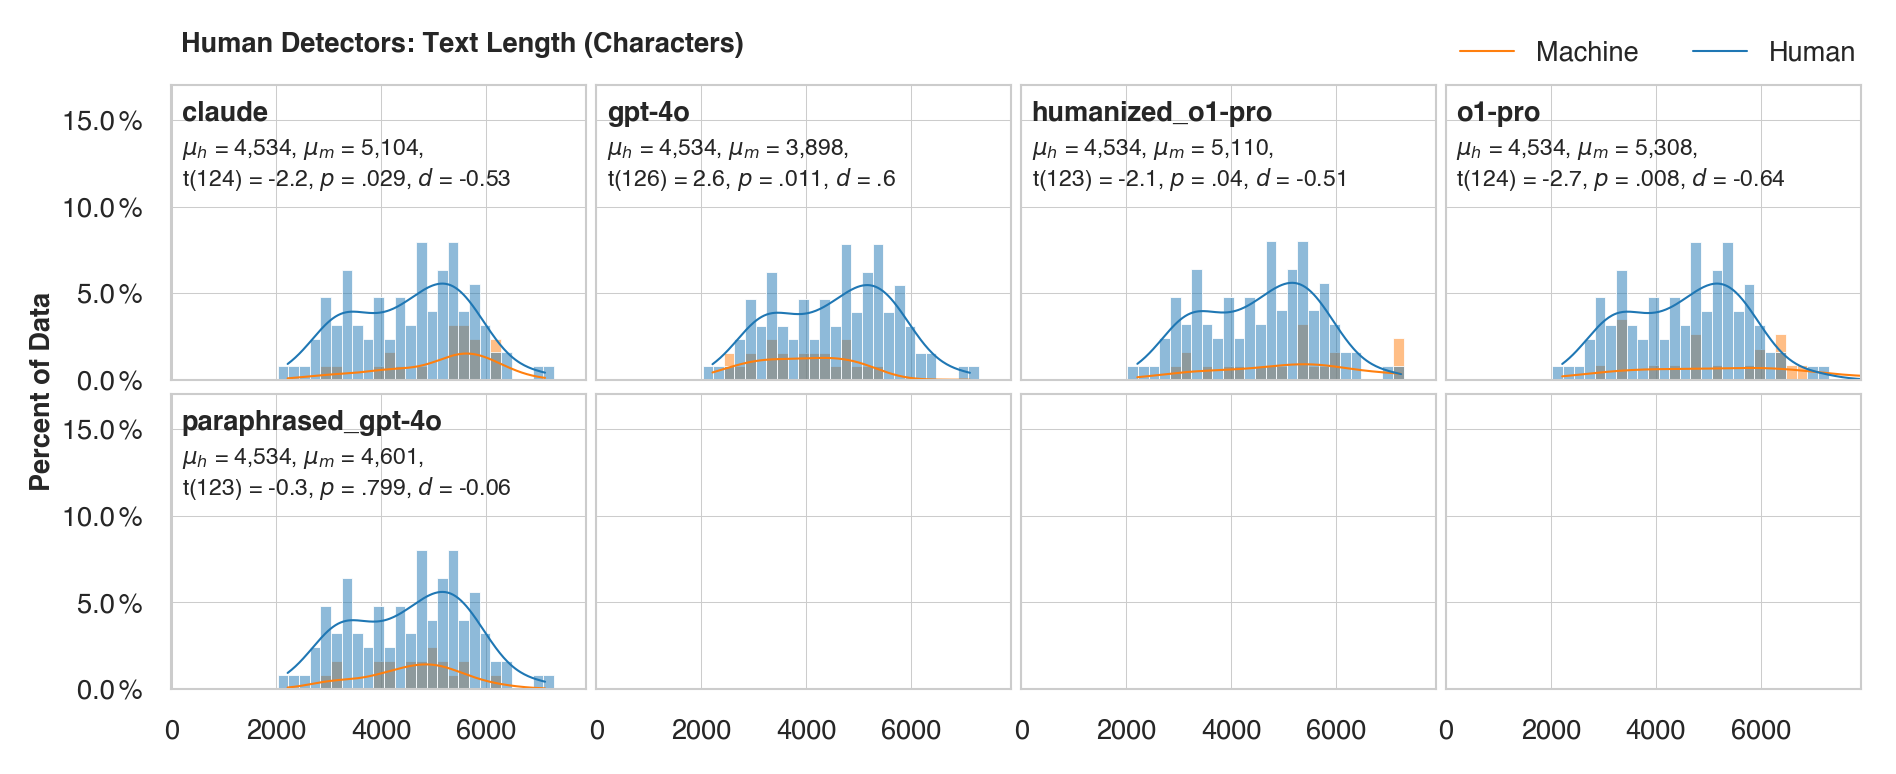

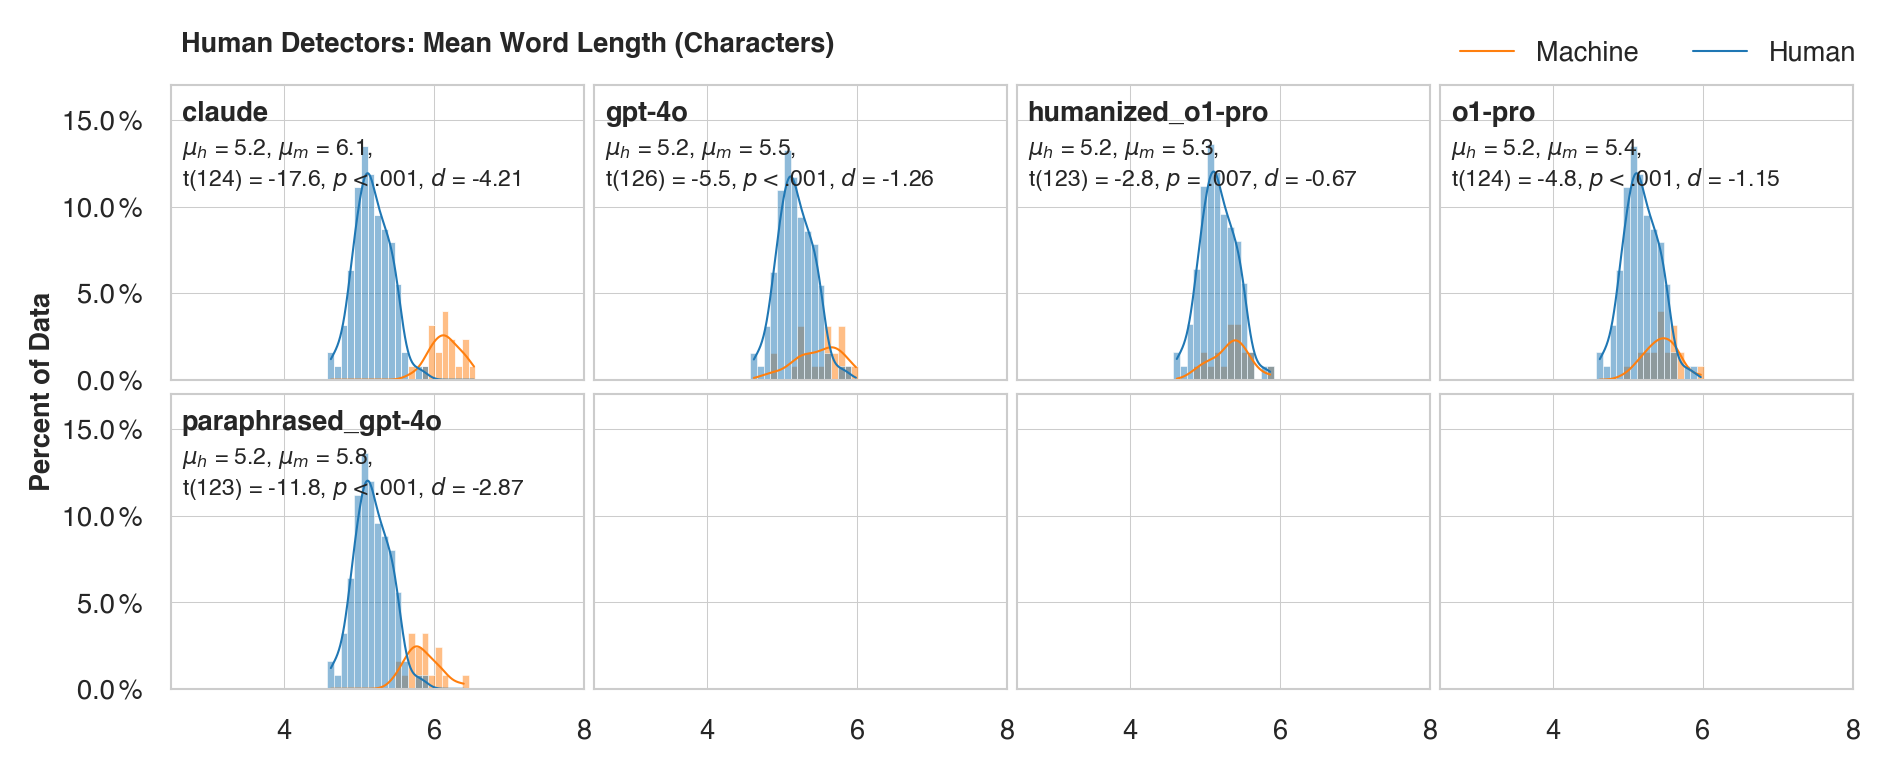

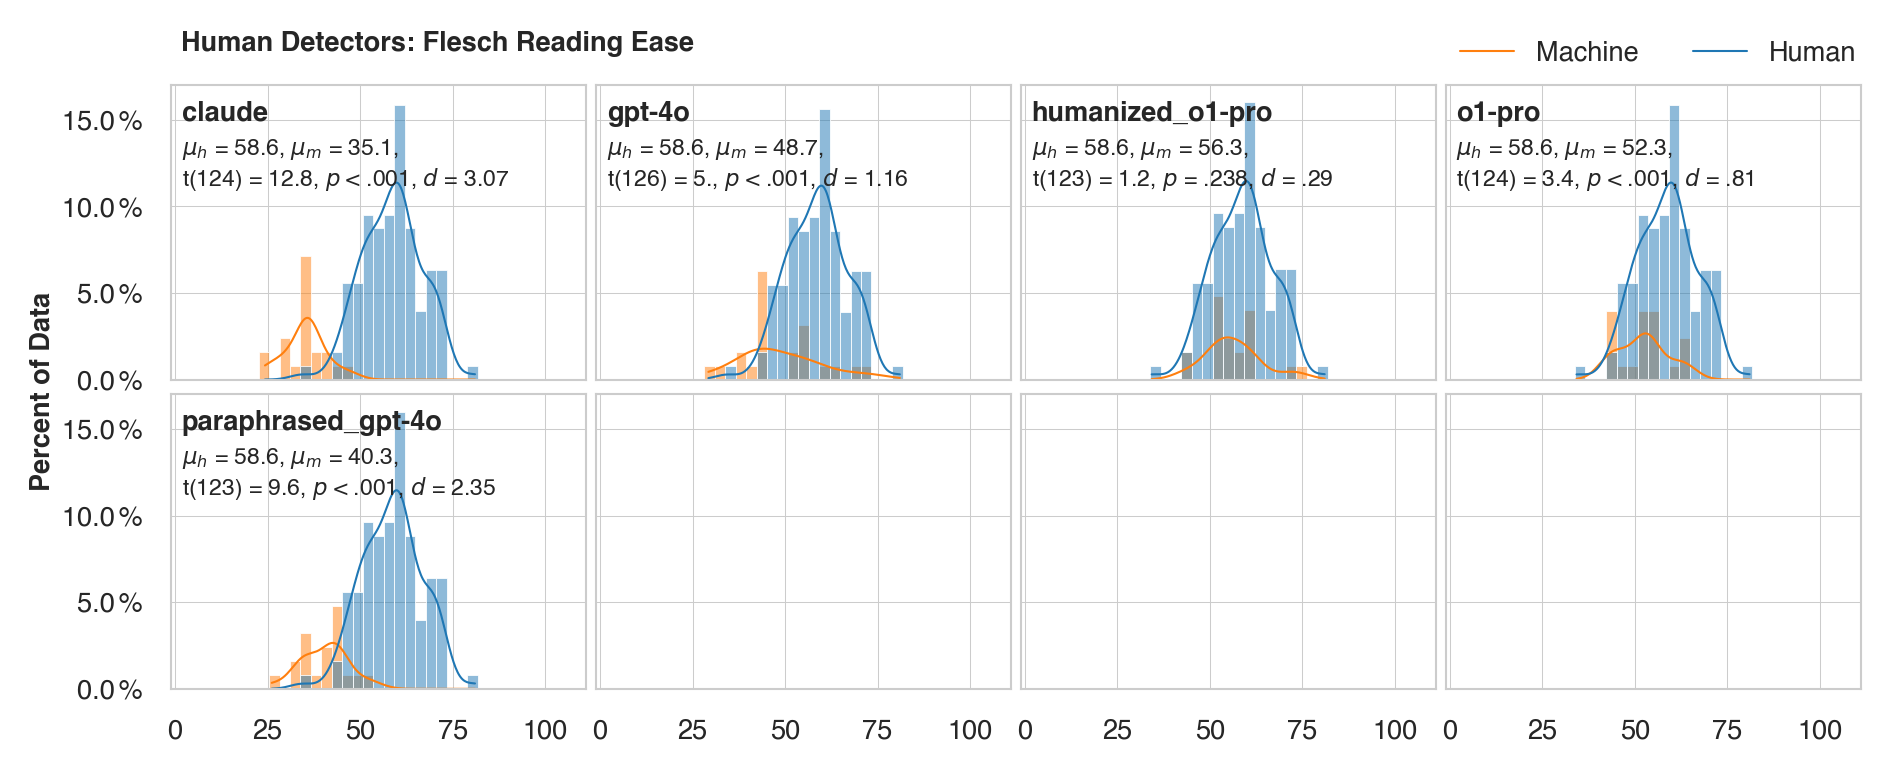

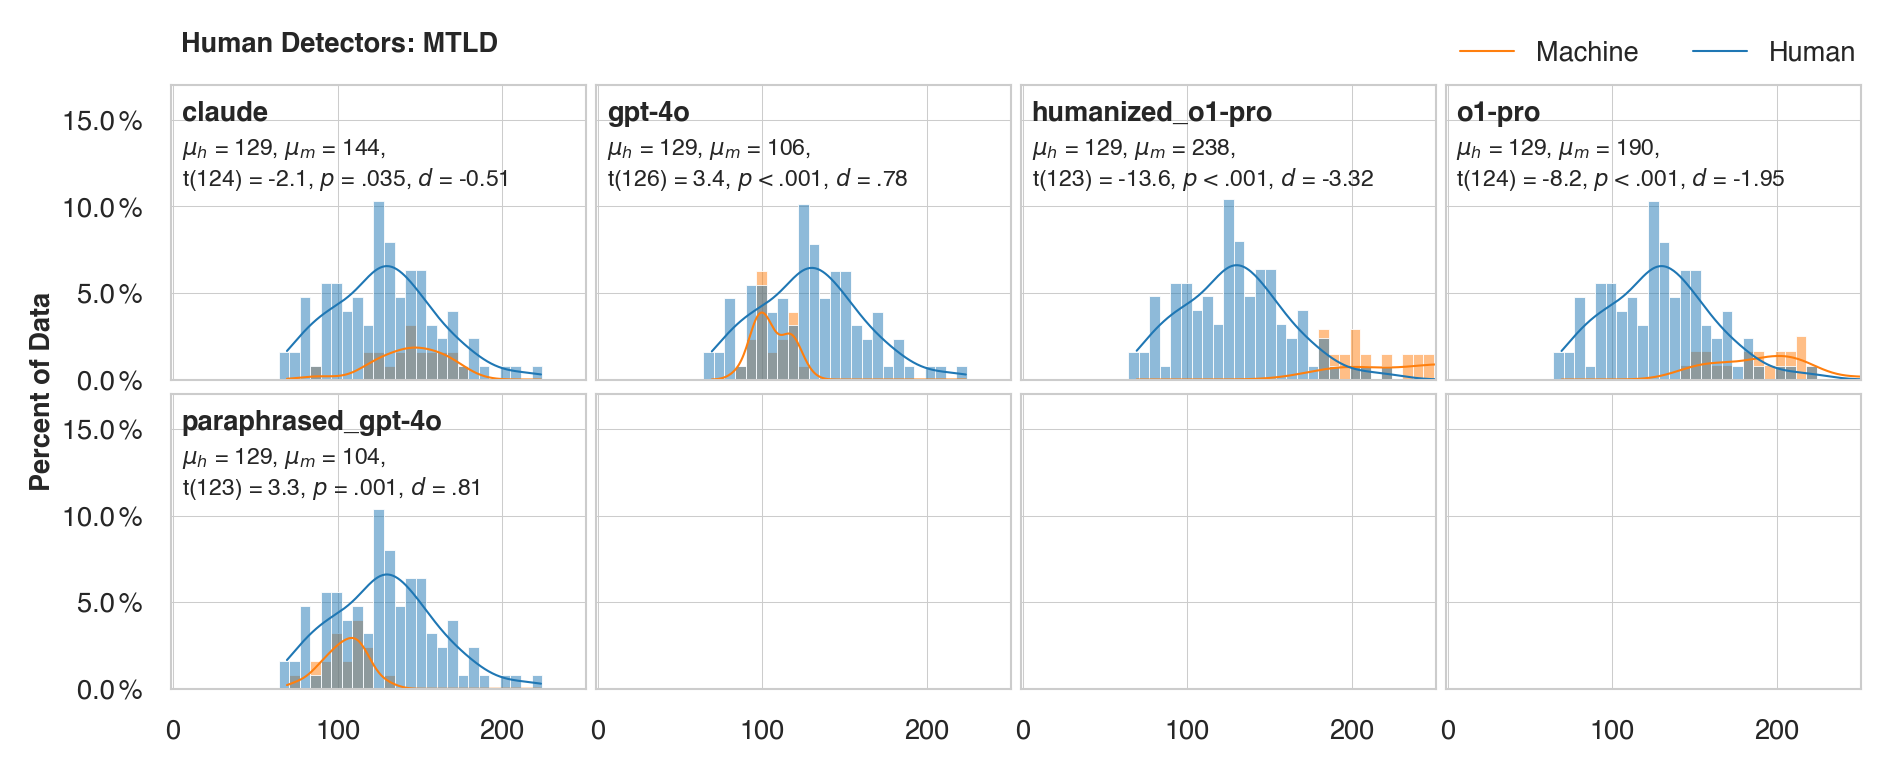

In [15]:
create_plots(df_hd, 'Human Detectors', 'human-detectors')

In [16]:
df_ghost_reuters = load_data('../data/datasets/ghostbuster-reuters-converted')

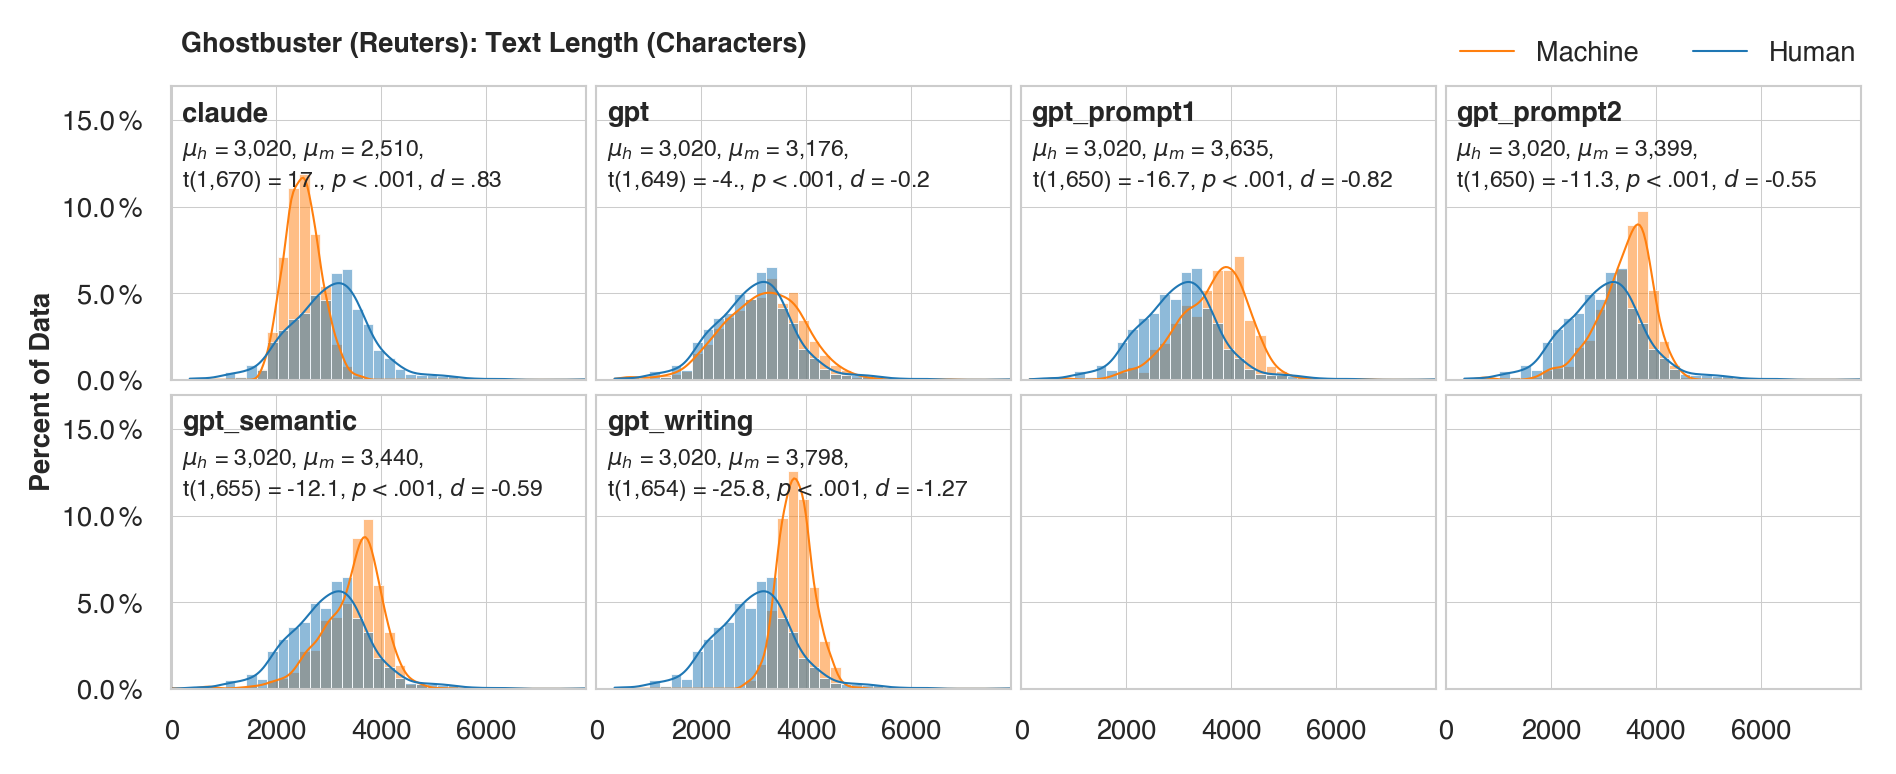

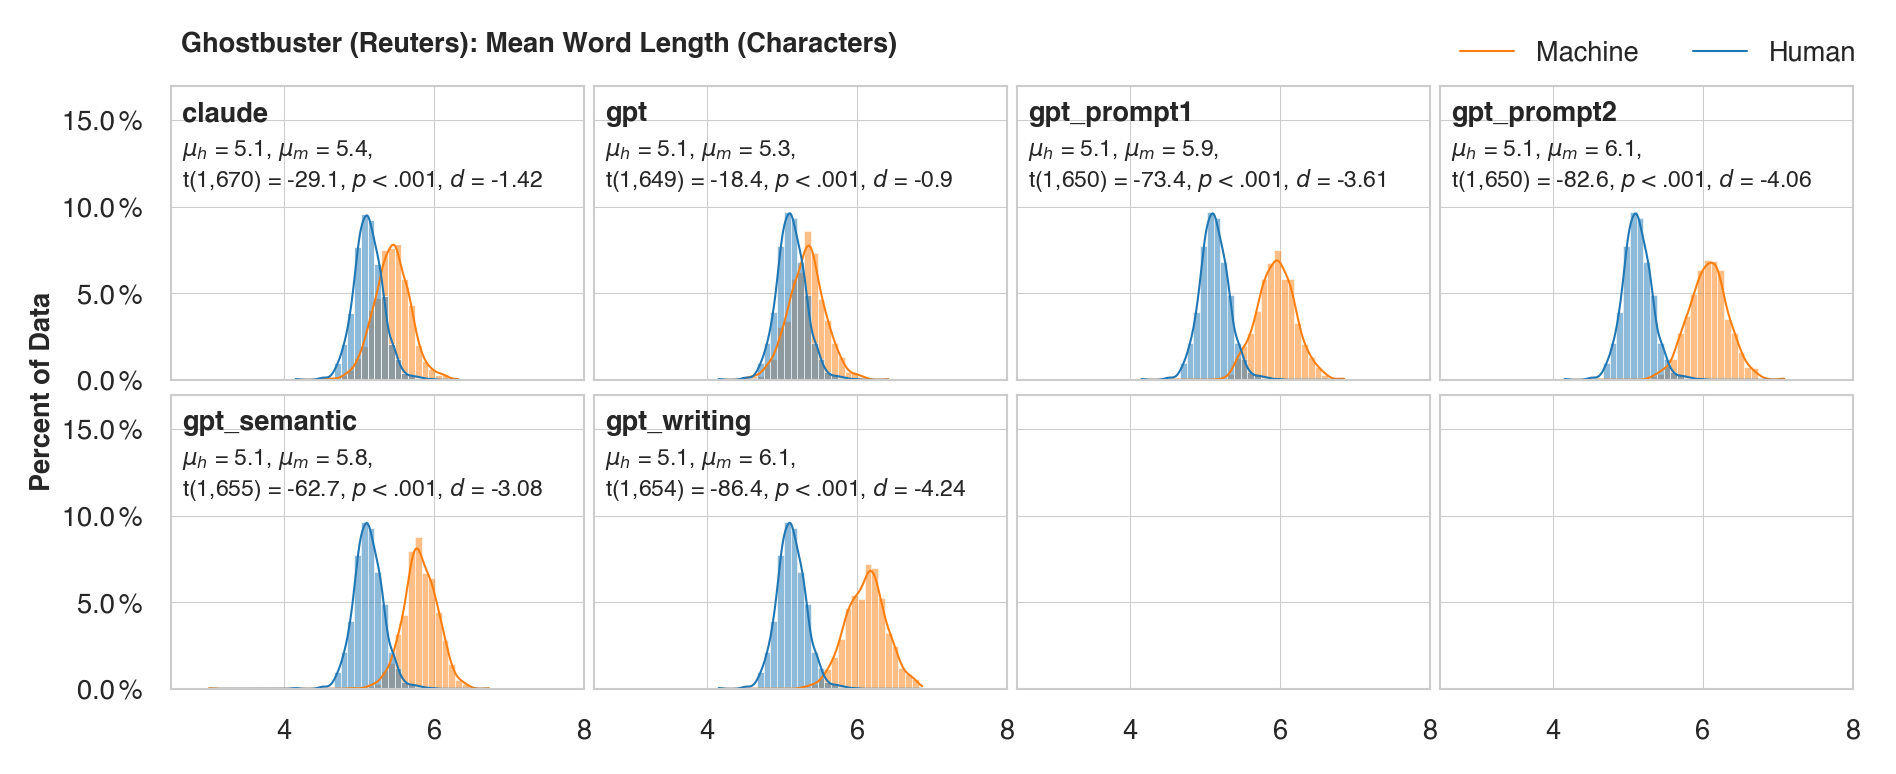

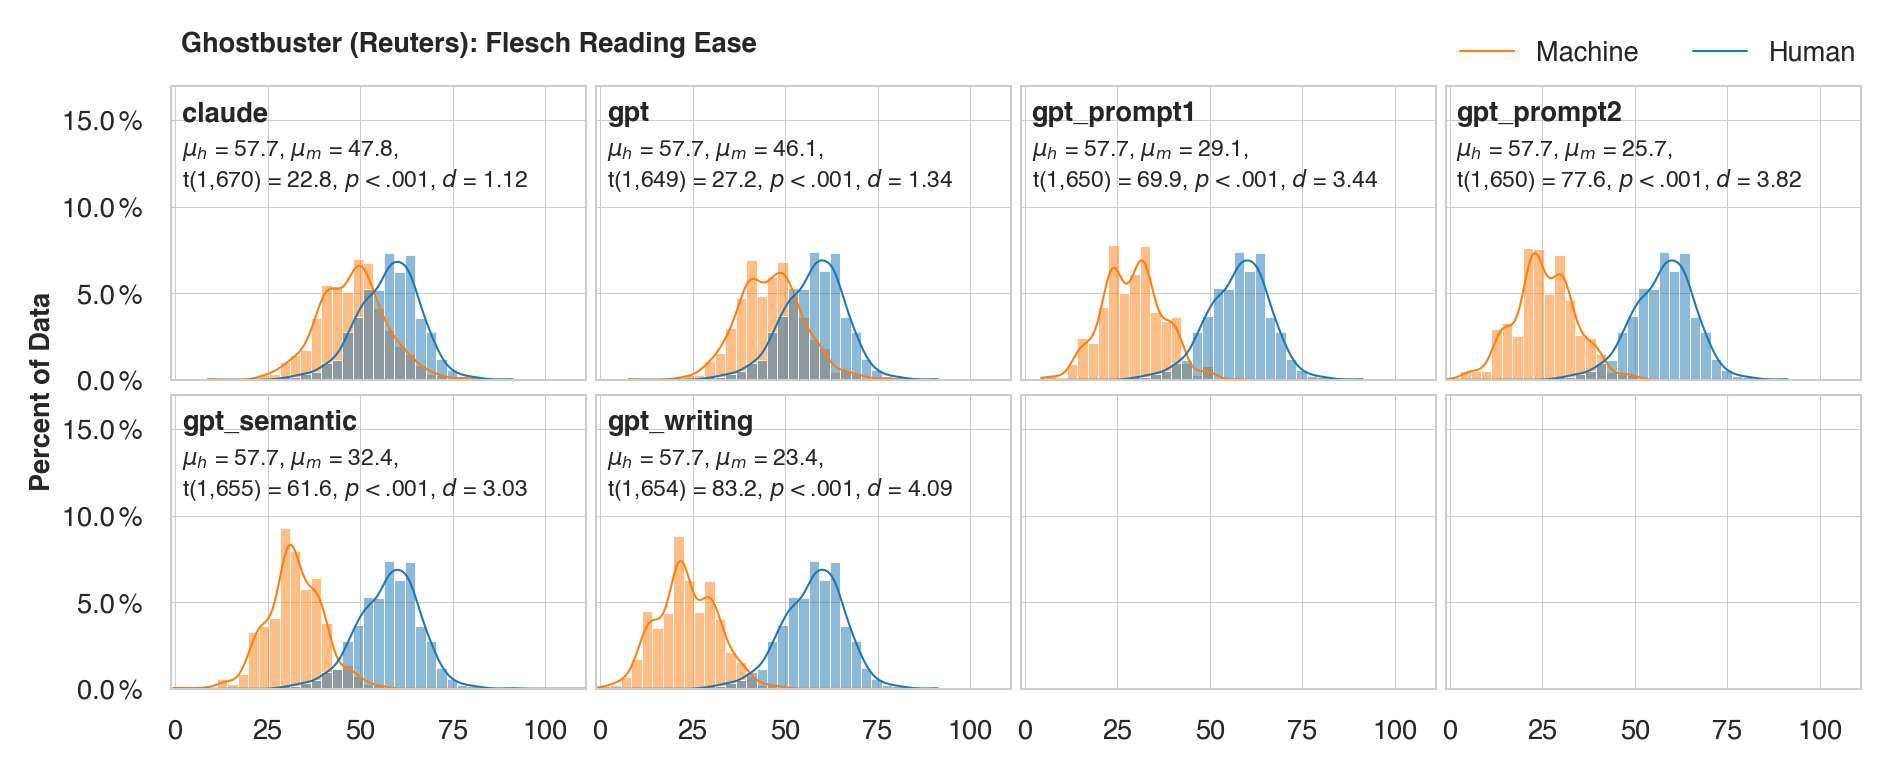

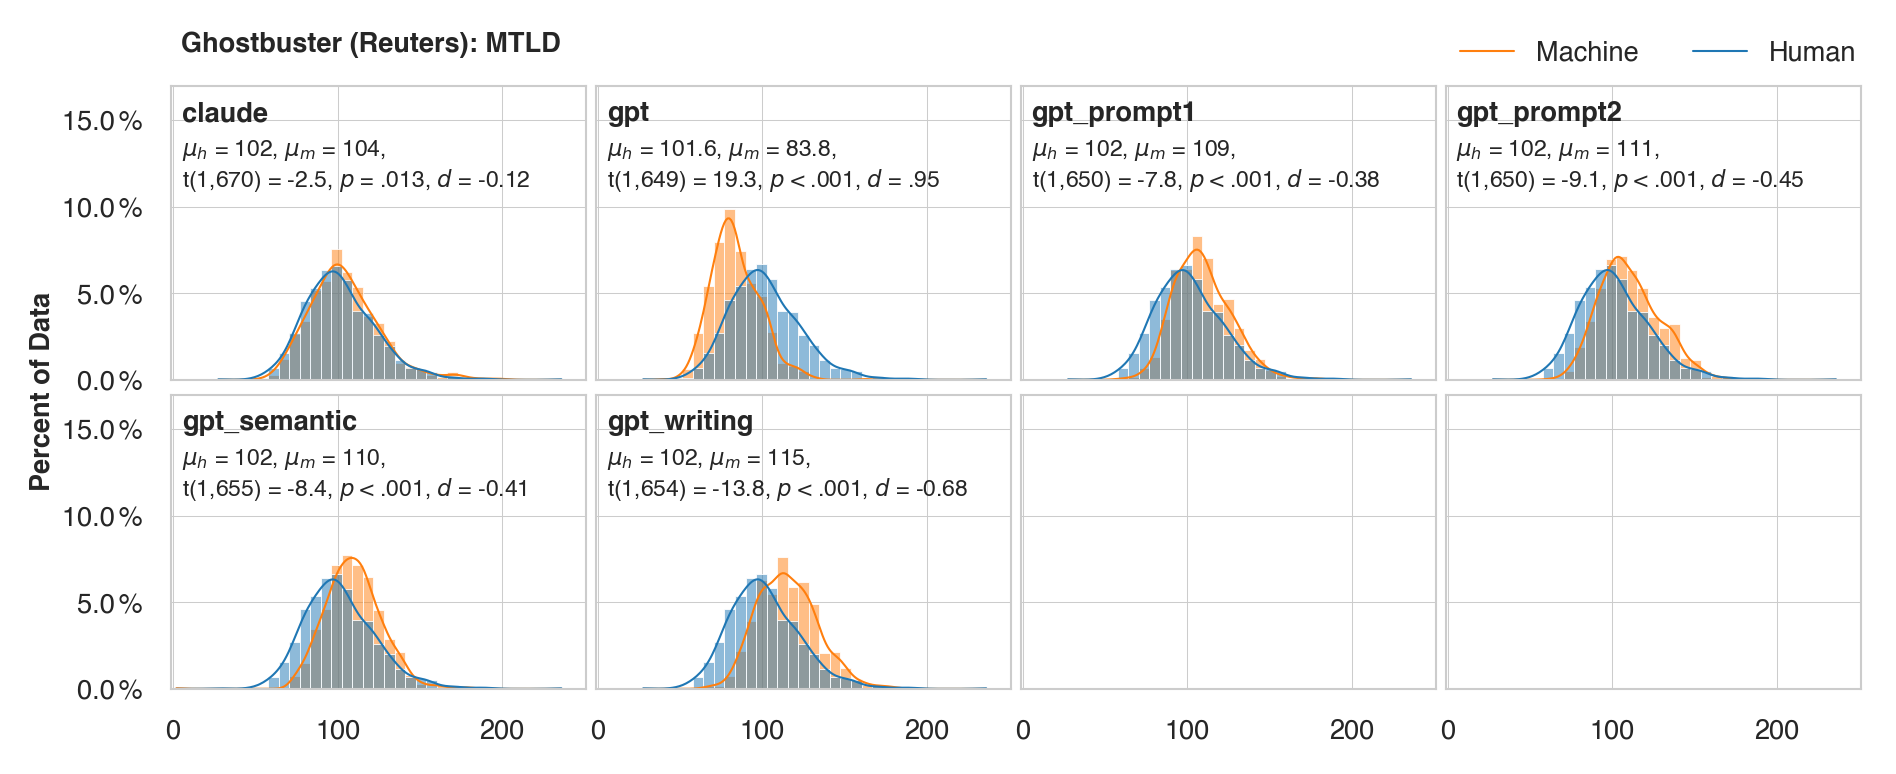

In [17]:
create_plots(df_ghost_reuters, 'Ghostbuster (Reuters)', 'ghostbuster-reuters')

In [18]:
df_ghost_essays = load_data('../data/datasets/ghostbuster-essay-converted')

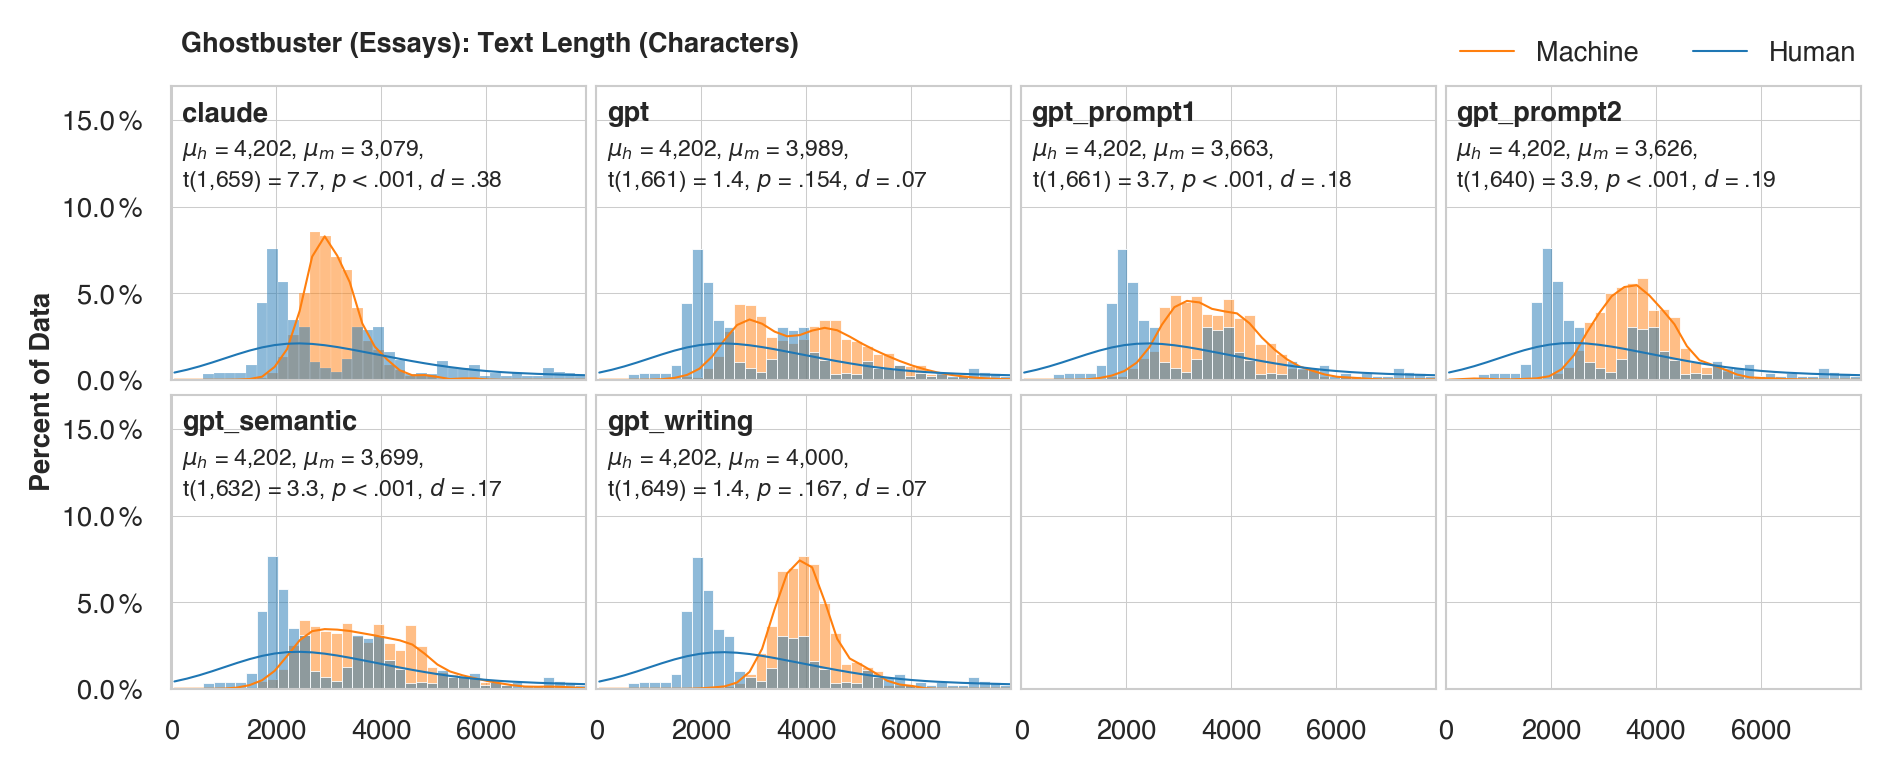

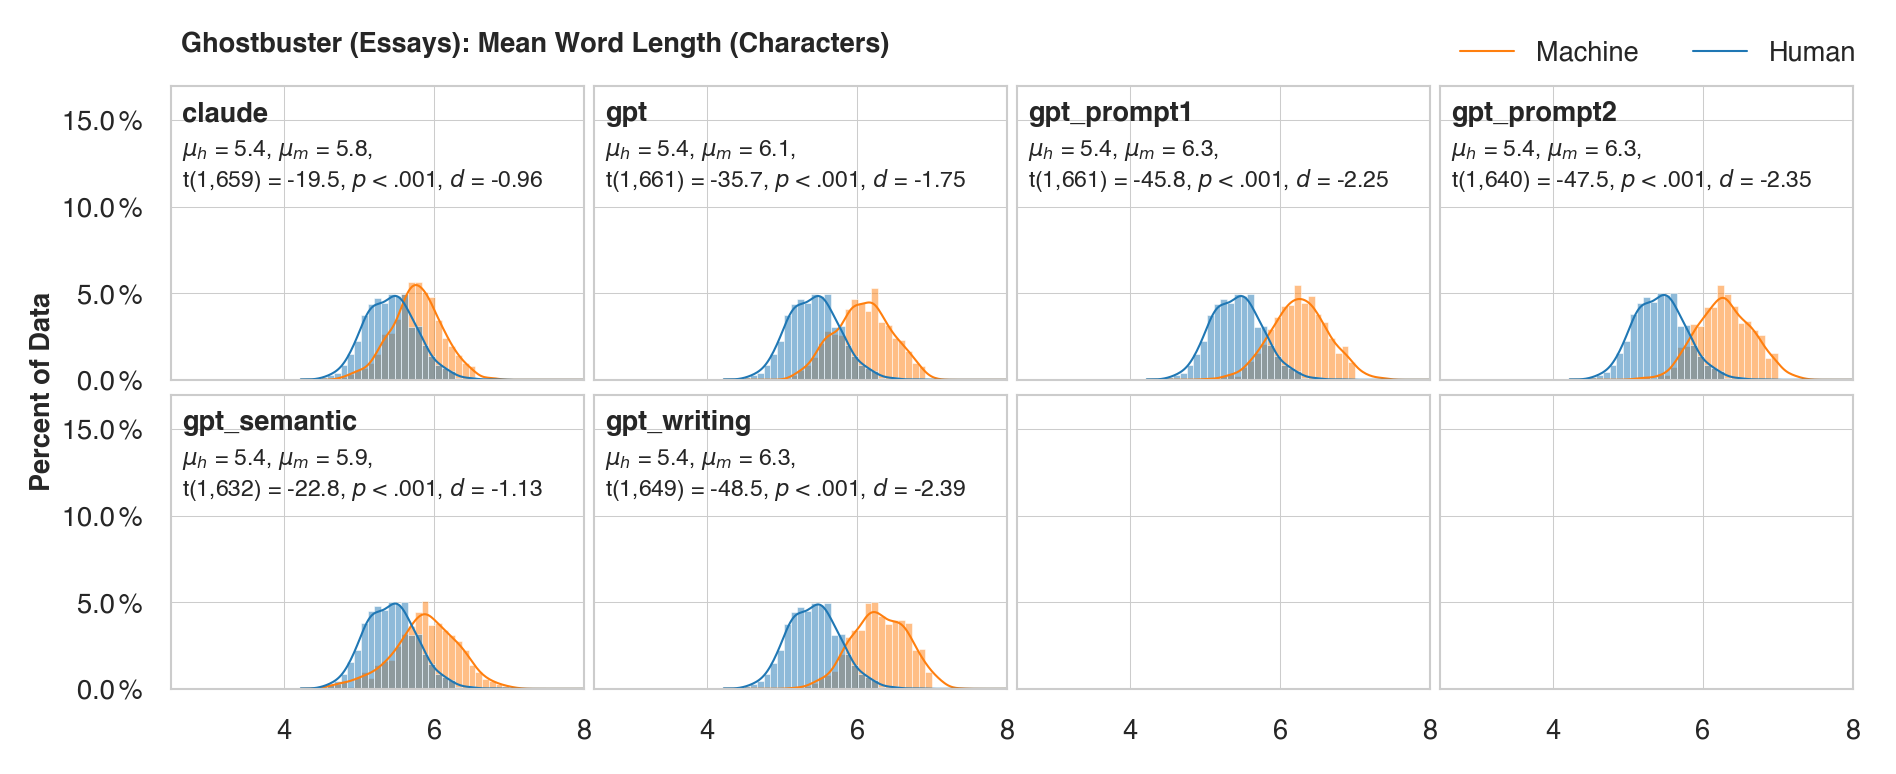

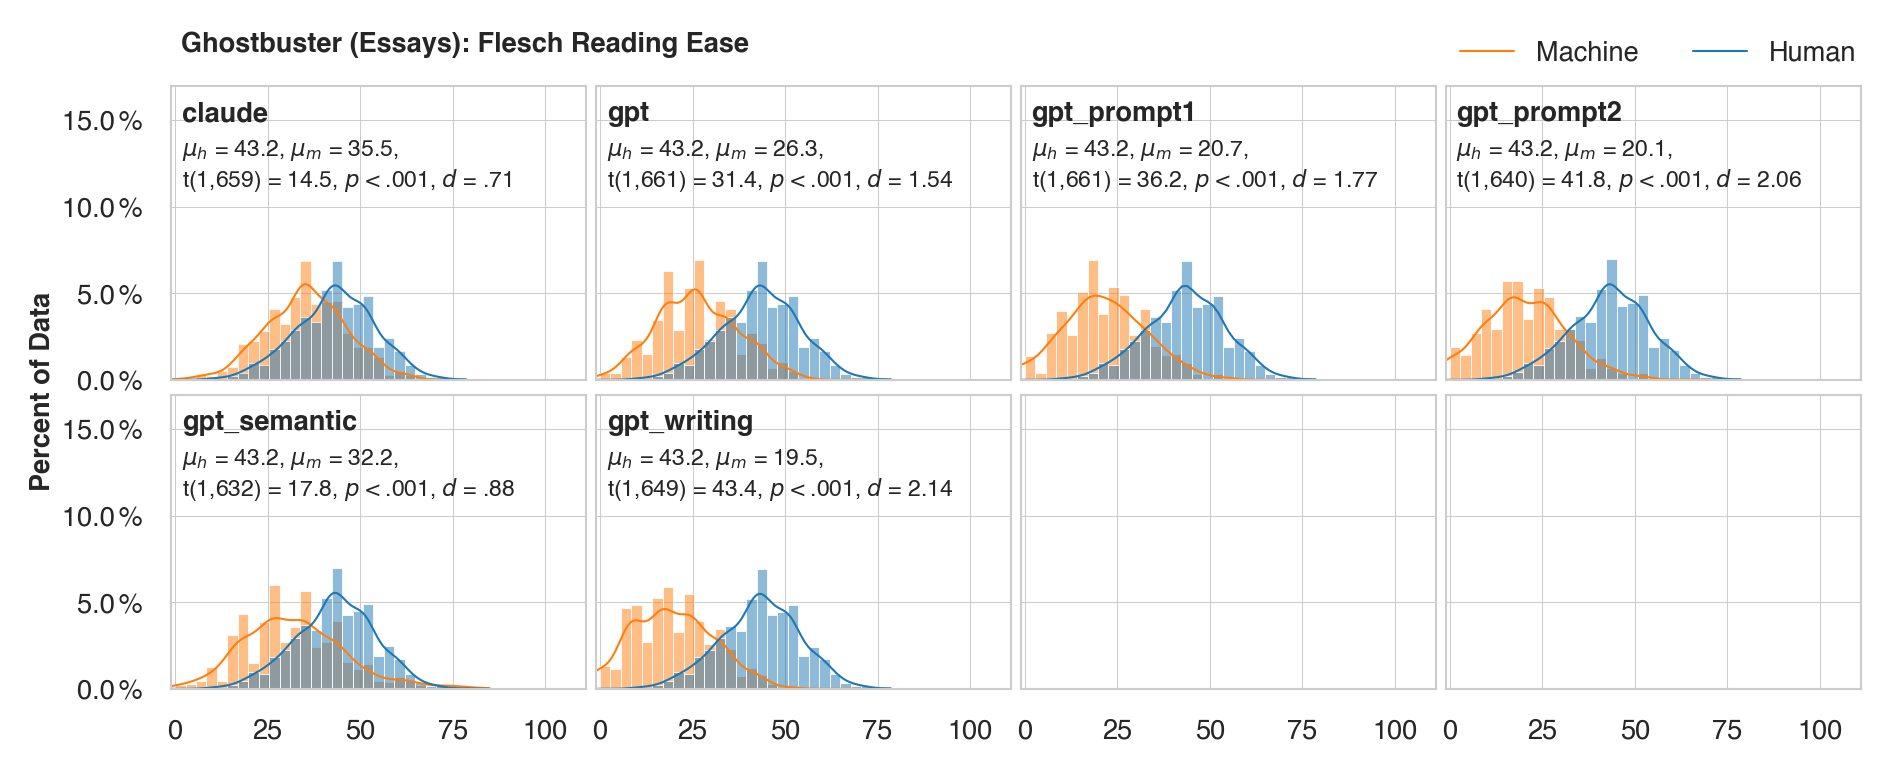

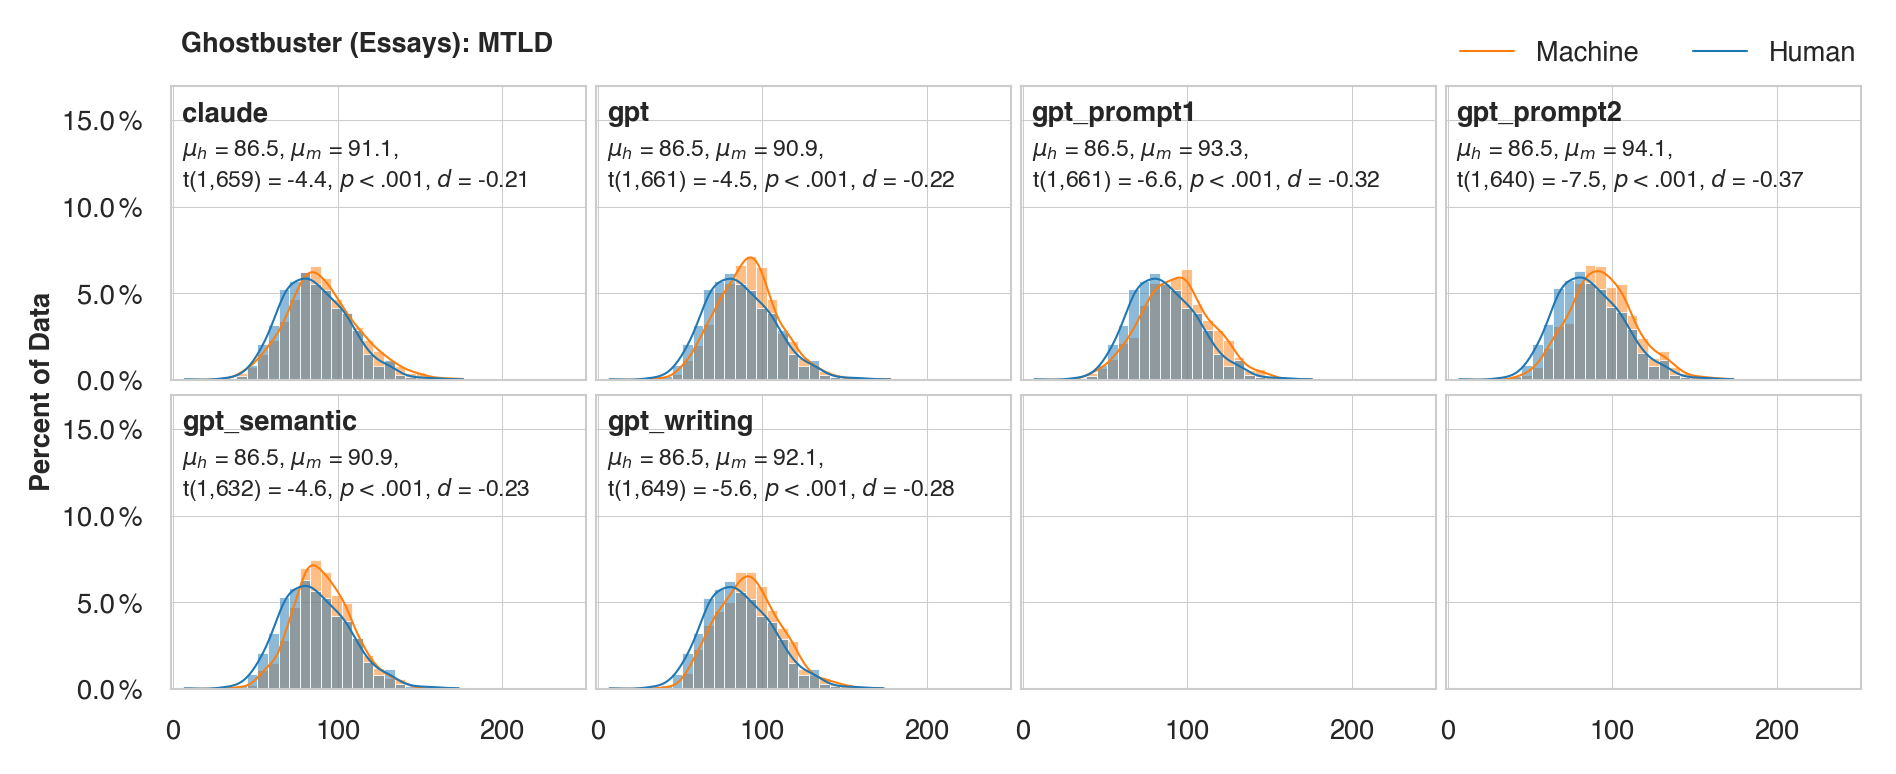

In [19]:
create_plots(df_ghost_essays, 'Ghostbuster (Essays)', 'ghostbuster-essays')

In [20]:
df_mage = load_data('../data/datasets/mage-converted').query('model.str.contains("human") or '
                                                             'model.str.contains("text-davinci") or '
                                                             'model.str.contains("gpt-3.5-trubo") or '  # sic!
                                                             'model.str.contains("gpt_neox") or '
                                                             'model.str.contains("gpt_j")')
df_mage['model'] = df_mage['model'].map(lambda m: m.replace('gpt_', 'gpt-').replace('trubo', 'turbo').split('_')[-1])
df_mage.groupby('model')['id'].count()

model
gpt-3.5-turbo       18154
gpt-j                6087
gpt-neox             5498
human               93318
text-davinci-002    17492
text-davinci-003    17693
Name: id, dtype: int64

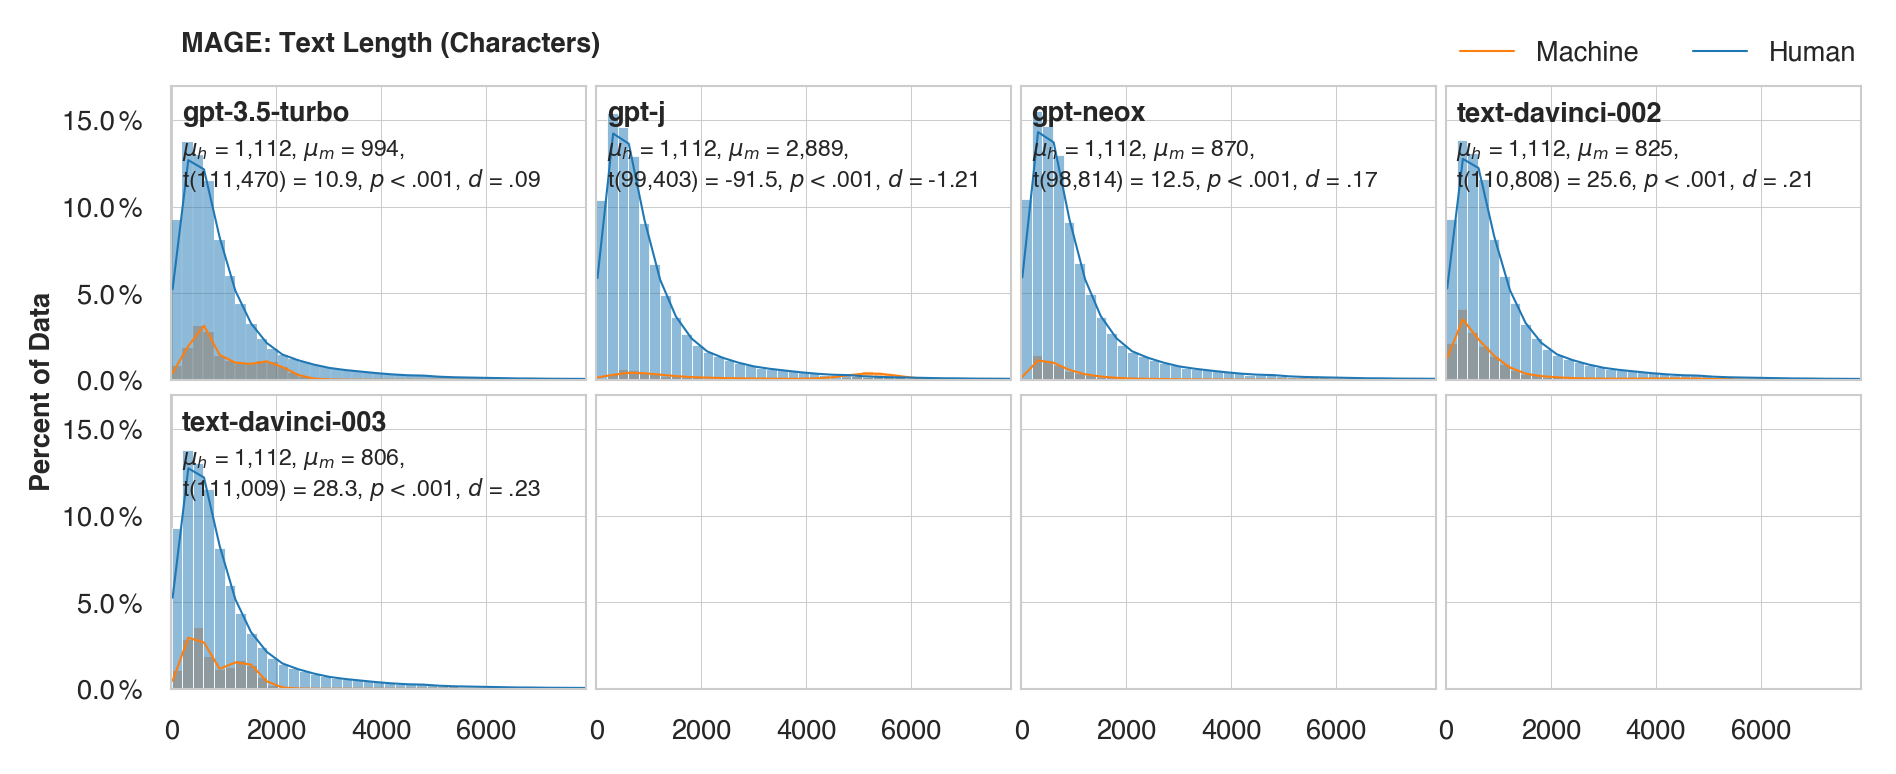

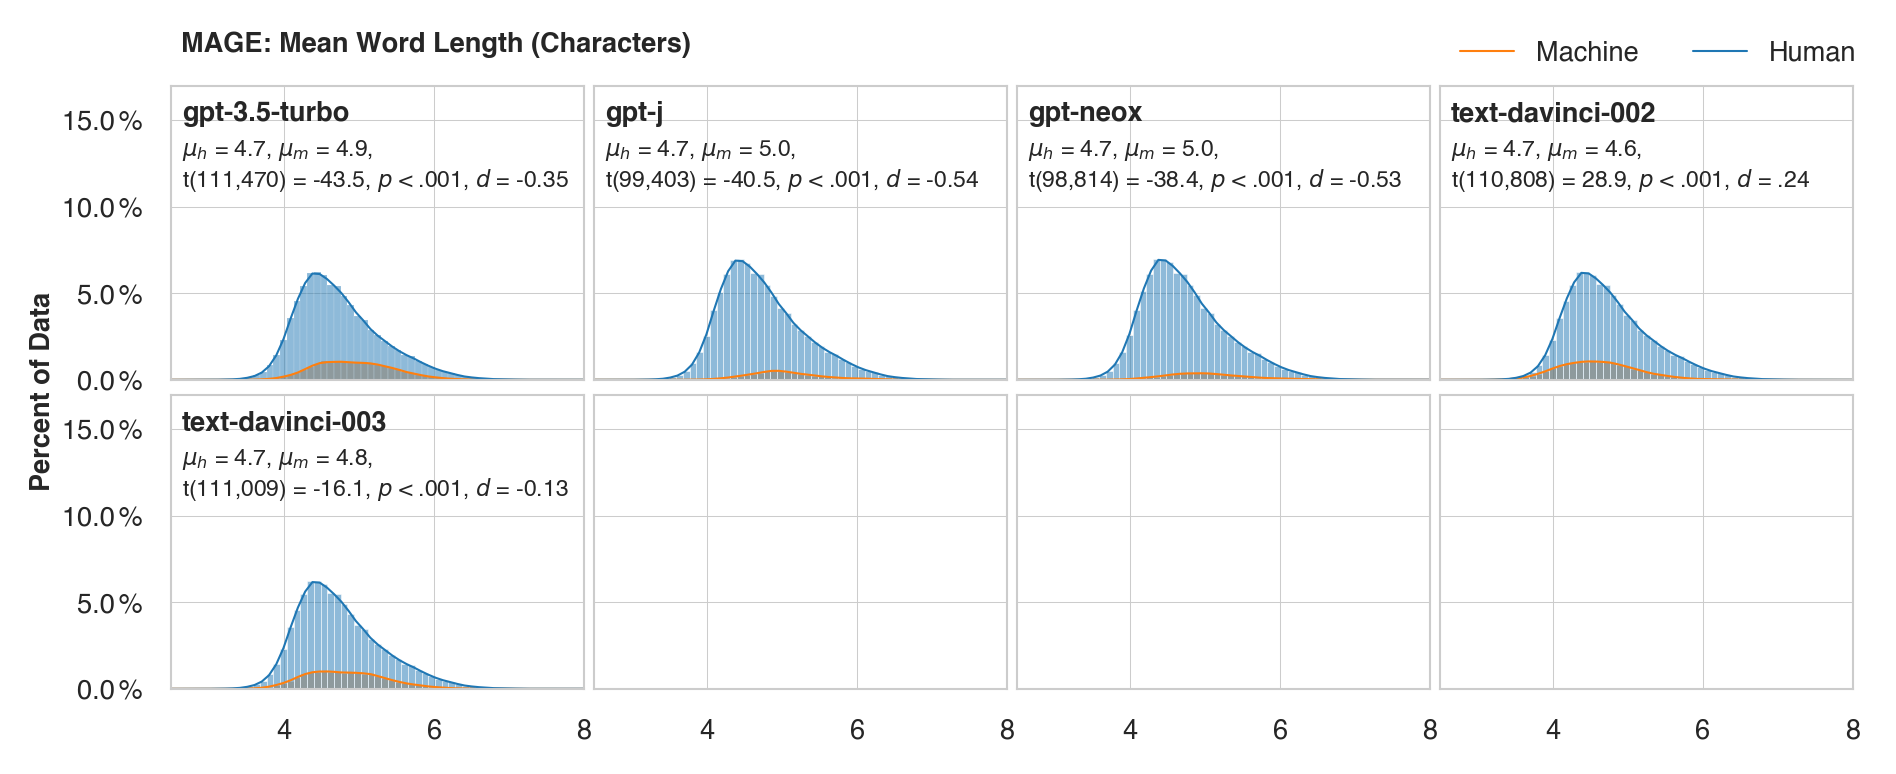

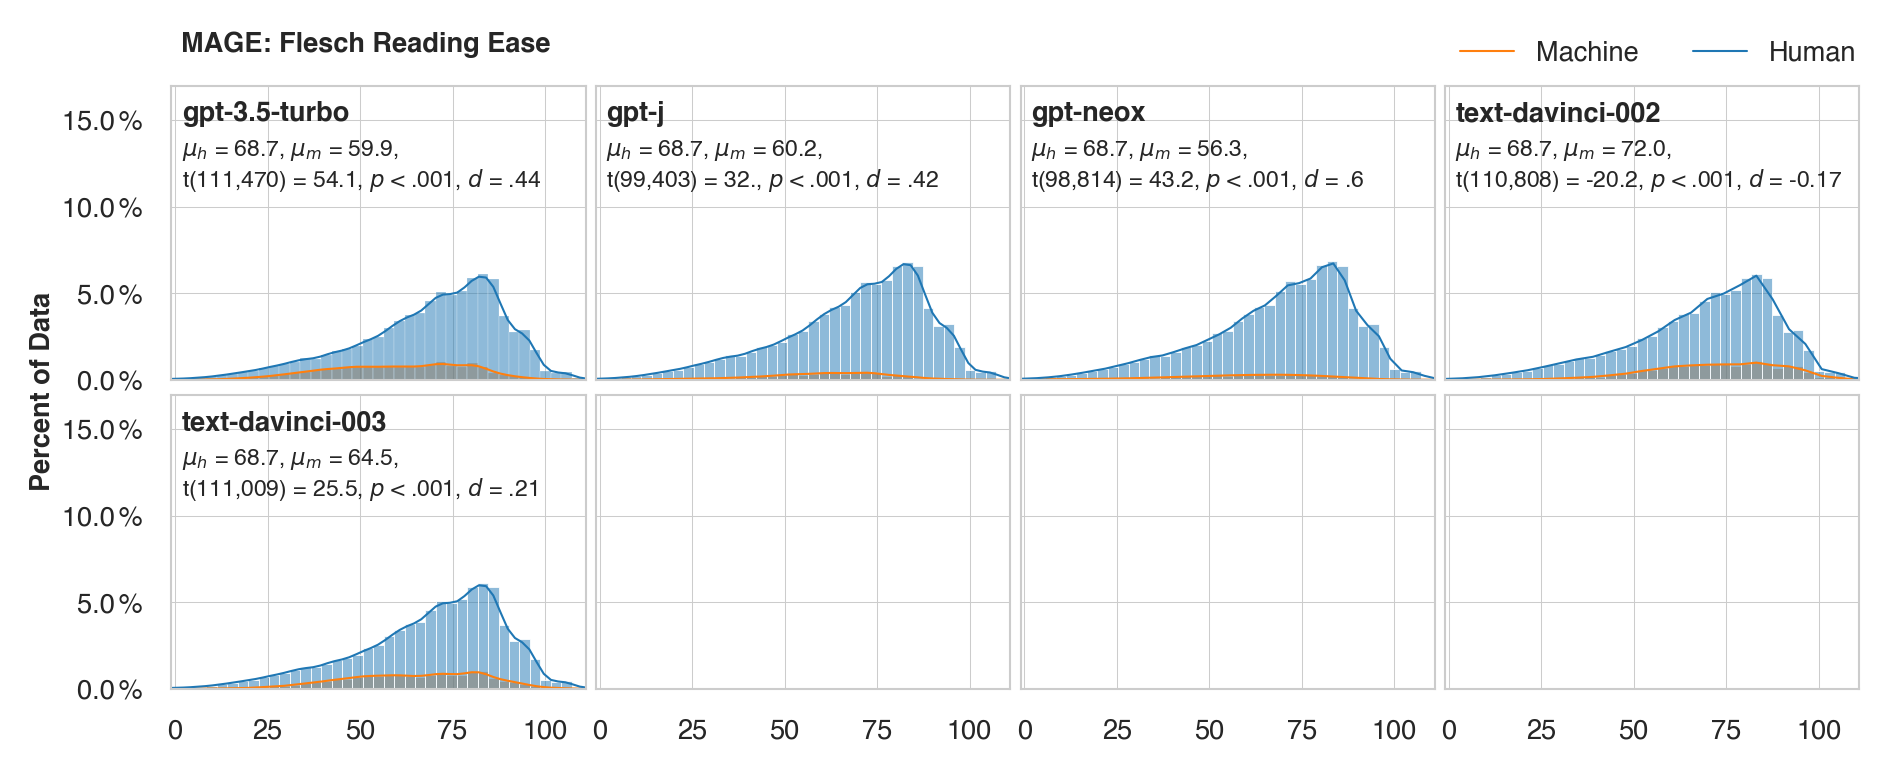

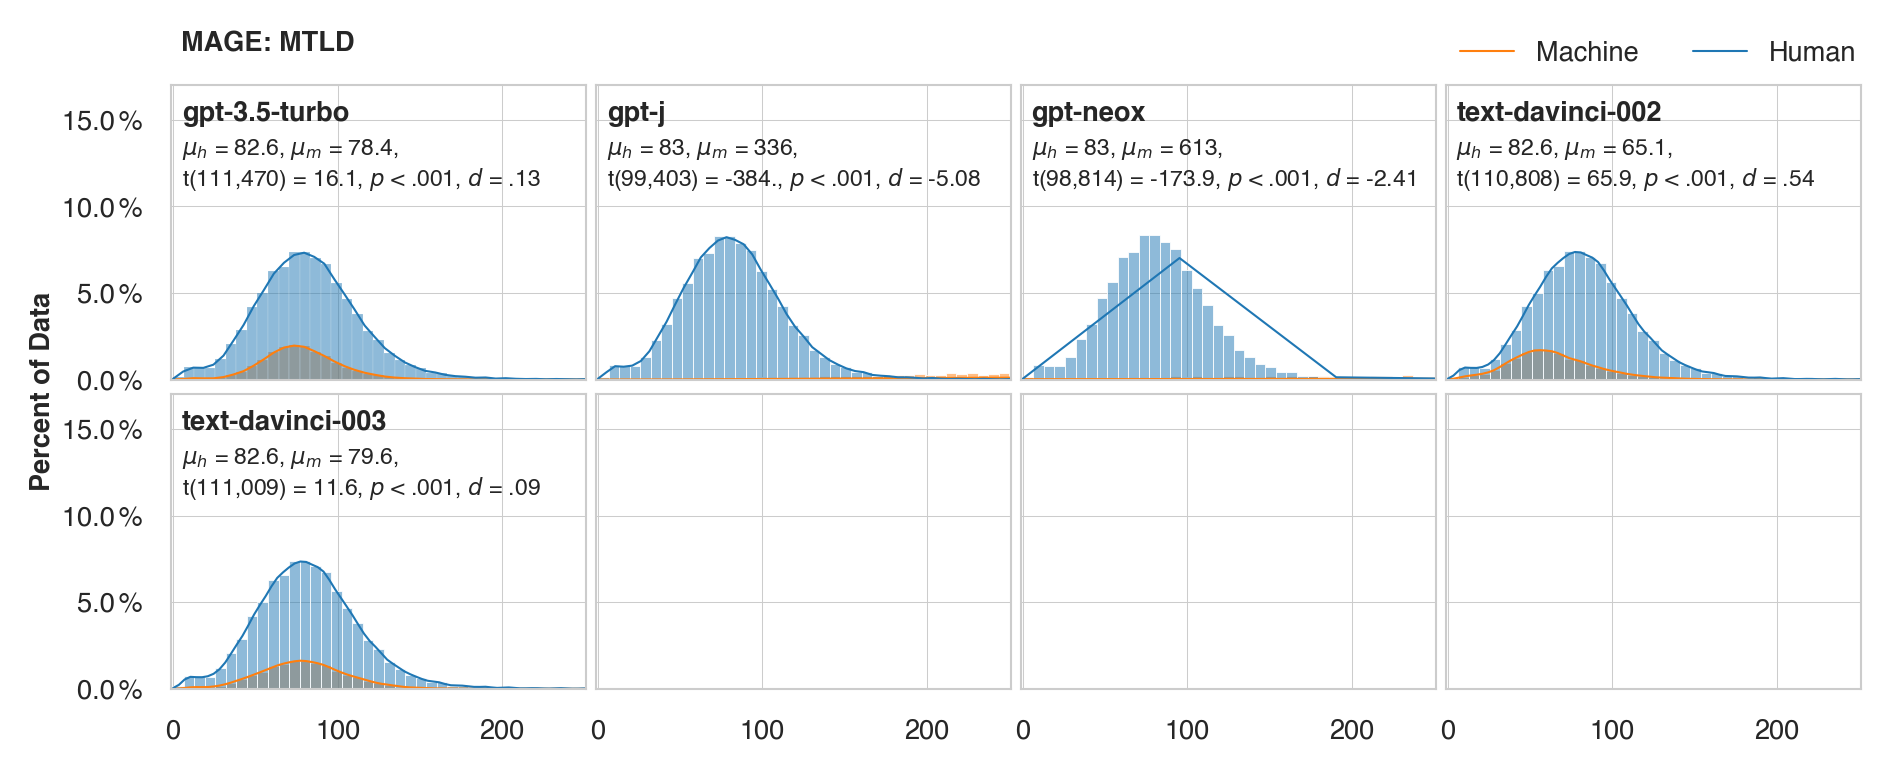

In [21]:
create_plots(df_mage, 'MAGE', 'mage')

In [22]:
df_m4 = load_data('../data/datasets/m4-converted')
df_m4.groupby('model')['id'].count()

model
bigscience/bloomz         11815
cohere                     1202
cohere-xlarge-nightly      2302
command-xlarge-nightly     5897
dolly-v2-12b               8583
gpt-3.5-turbo             14759
human                     58118
text-davinci-003          11809
Name: id, dtype: int64

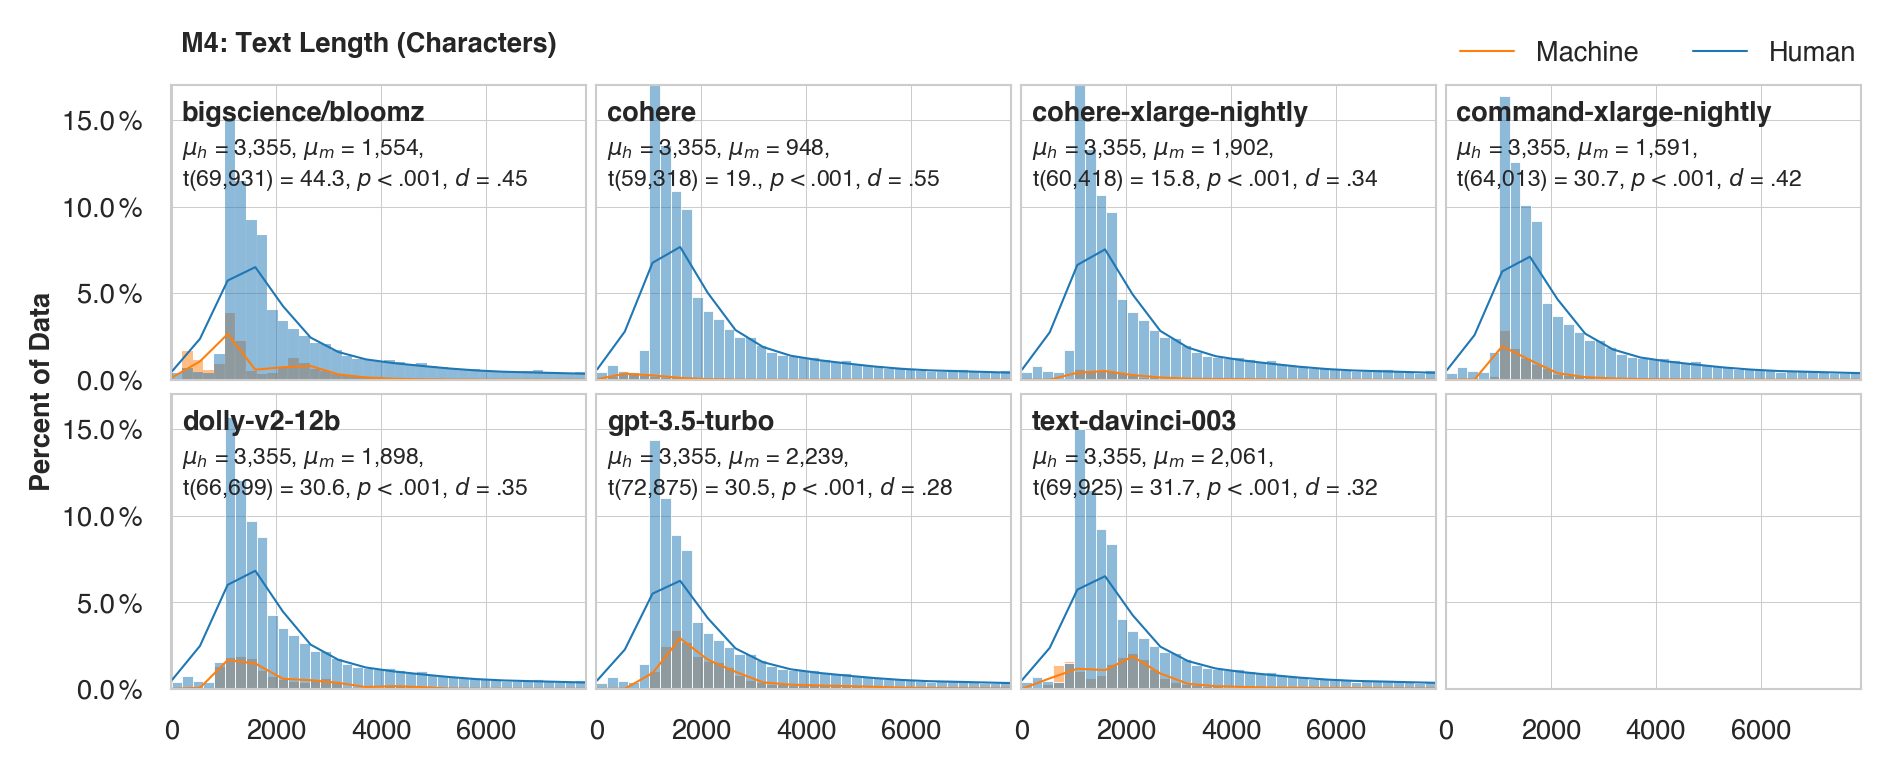

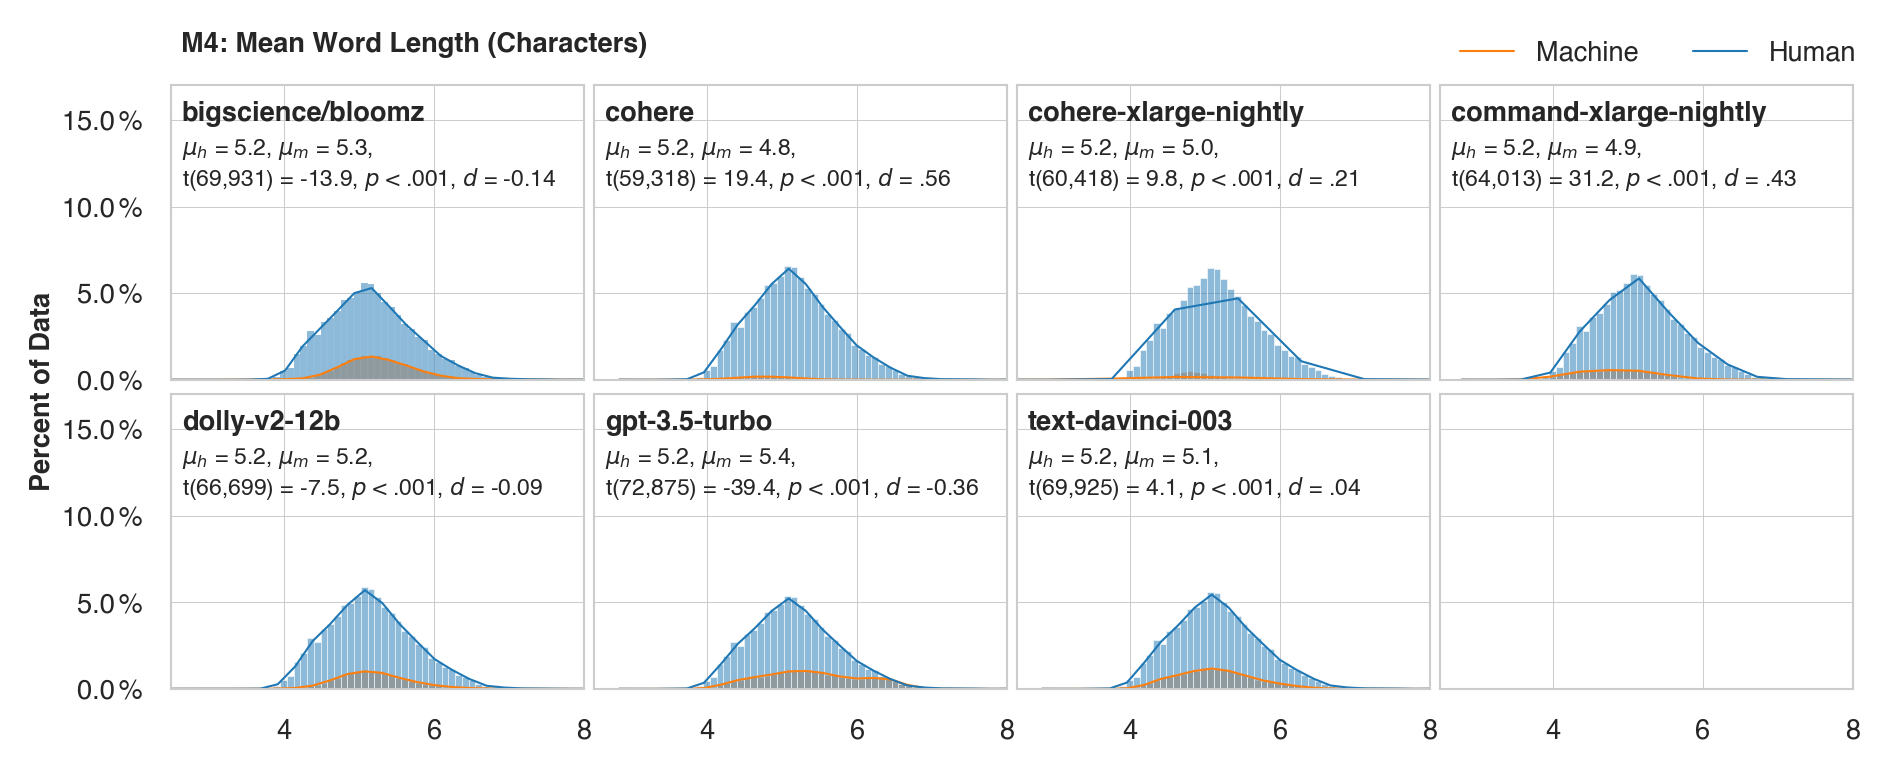

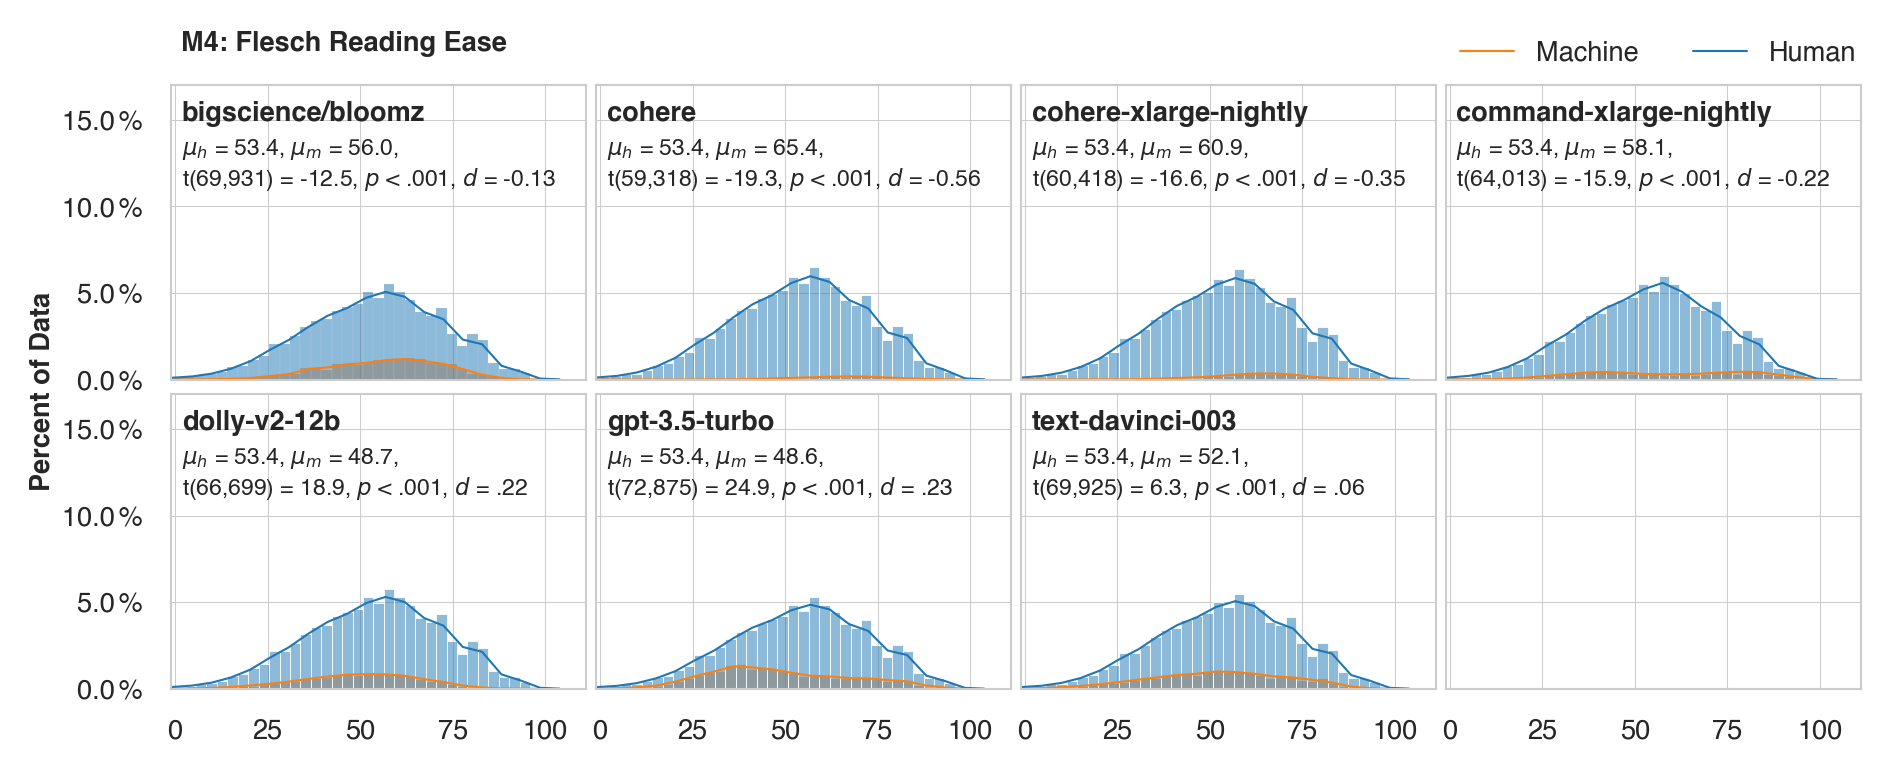

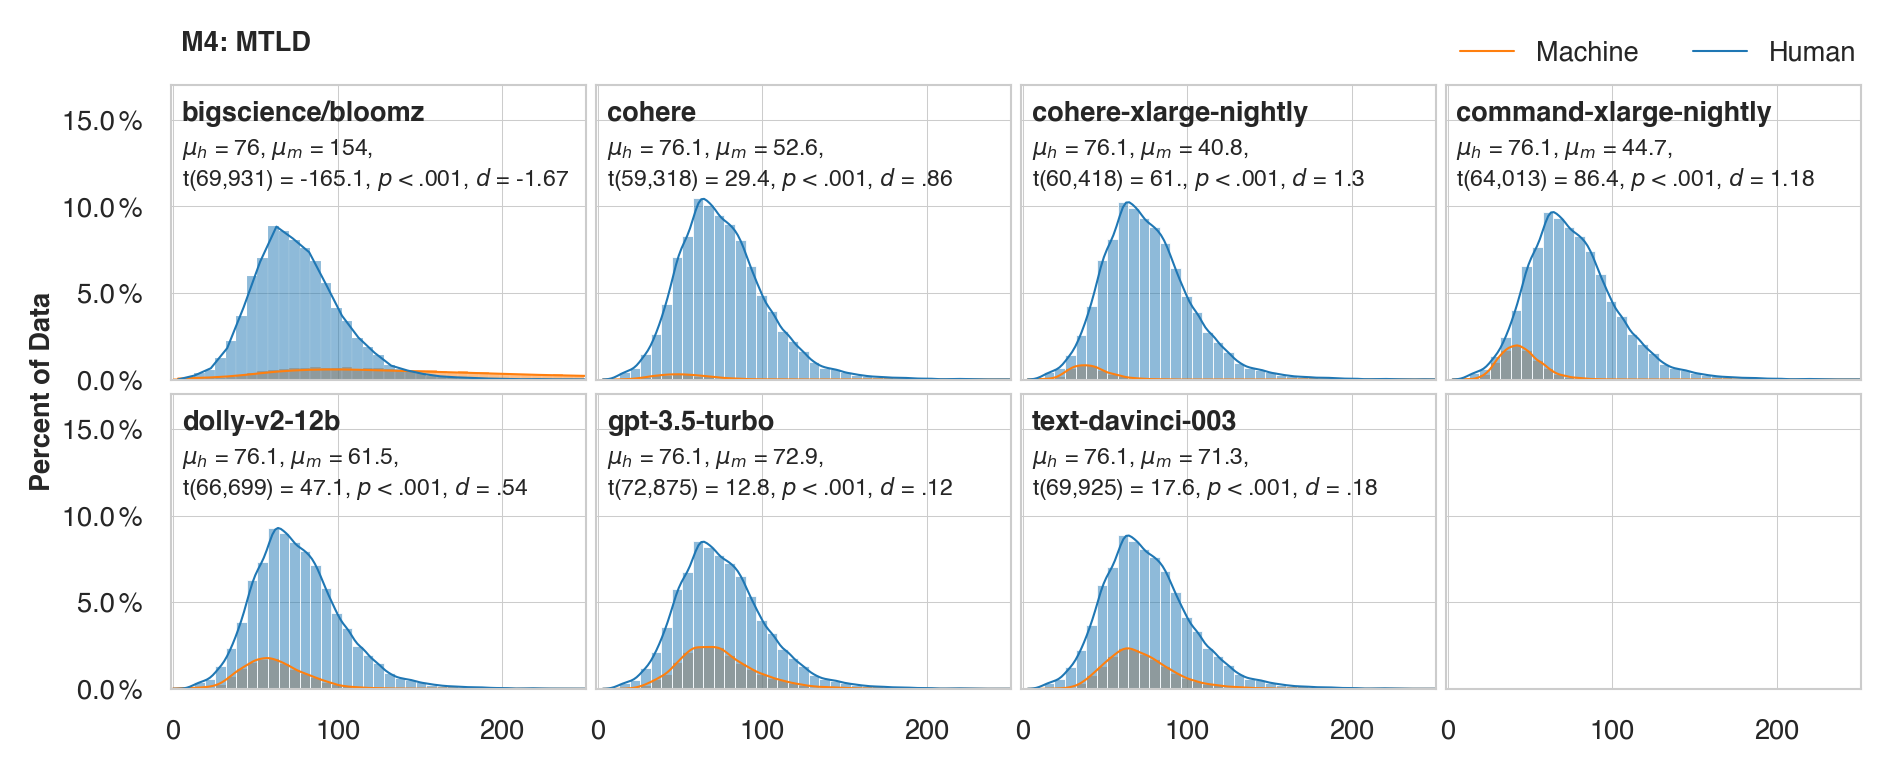

In [23]:
create_plots(df_m4, 'M4', 'm4')